In [13]:
# Import necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define constants
IMG_WIDTH, IMG_HEIGHT = 224, 224
# Set the batch size
batch_size = 32

# Set the number of epochs
epochs = 10
img_size = (224, 224)
# Set the path to the dataset
train_dir = "D:/BRAIN DATA/bt mri 7023/training"
test_dir = "D:/BRAIN DATA/bt mri 7023/testing"

BATCH_SIZE = 32

# Define data augmentation and normalization
data_gen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
    rotation_range=30,  # Randomly rotate images
    width_shift_range=0.1,  # Randomly shift images horizontally
    height_shift_range=0.1,  # Randomly shift images vertically
)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# Load and preprocess training data
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure that the test data is not shuffled
)




Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


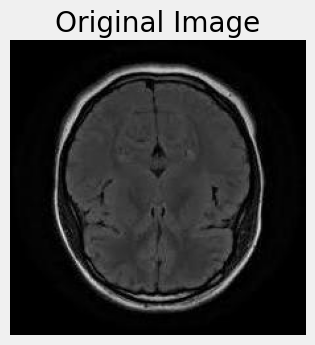

(224, 224, 3)


In [370]:

# Create a sample image to visualize preprocessing
sample_img = next(train_generator)[0][0]

# Original Image
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.imshow(sample_img)
plt.title('Original Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print the shape of the preprocessed image
print(sample_img.shape)


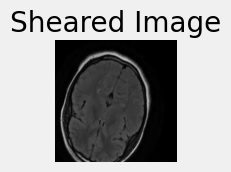

(224, 224, 3)


In [371]:
# Shear
sheared_img = sample_img.copy()
sheared_img = data_gen.random_transform(sheared_img)
plt.subplot(3, 3, 2)
plt.imshow(sheared_img)
plt.title('Sheared Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print the shape of the preprocessed image
print(sample_img.shape)

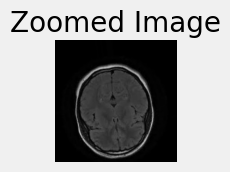

(224, 224, 3)


In [372]:

# Zoom
zoomed_img = sample_img.copy()
zoomed_img = data_gen.random_transform(zoomed_img)
plt.subplot(3, 3, 3)
plt.imshow(zoomed_img)
plt.title('Zoomed Image')
plt.axis('off')



plt.tight_layout()
plt.show()

# Print the shape of the preprocessed image
print(sample_img.shape)

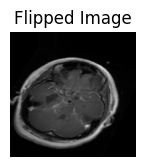

(224, 224, 3)


In [17]:
# Horizontal Flip
flipped_img = sample_img.copy()
flipped_img = data_gen.random_transform(flipped_img)
plt.subplot(3, 3, 4)
plt.imshow(flipped_img)
plt.title('Flipped Image')
plt.axis('off')


plt.tight_layout()
plt.show()

# Print the shape of the preprocessed image
print(sample_img.shape)

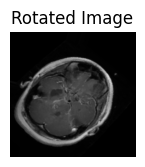

(224, 224, 3)


In [18]:
# Rotation
rotated_img = sample_img.copy()
rotated_img = data_gen.random_transform(rotated_img)
plt.subplot(3, 3, 5)
plt.imshow(rotated_img)
plt.title('Rotated Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print the shape of the preprocessed image
print(sample_img.shape)

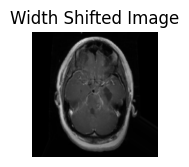

(224, 224, 3)


In [19]:

# Width Shift
shifted_img = sample_img.copy()
shifted_img = data_gen.random_transform(shifted_img)
plt.subplot(3, 3, 6)
plt.imshow(shifted_img)
plt.title('Width Shifted Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print the shape of the preprocessed image
print(sample_img.shape)

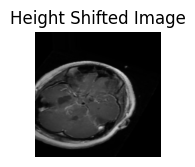

(224, 224, 3)


In [20]:

# Height Shift
shifted_img = sample_img.copy()
shifted_img = data_gen.random_transform(shifted_img)
plt.subplot(3, 3, 7)
plt.imshow(shifted_img)
plt.title('Height Shifted Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print the shape of the preprocessed image
print(sample_img.shape)

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall, AUC, RootMeanSquaredError
import tensorflow.keras.backend as K
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, jaccard_score, r2_score

# Define custom metrics
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon())

def cohen_kappa(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)
    confusion = tf.math.confusion_matrix(y_true, y_pred, num_classes=4)
    n = K.sum(confusion)
    sum_po = K.sum(tf.linalg.diag_part(confusion))
    po = sum_po / n
    pe = K.sum(K.sum(confusion, axis=0) * K.sum(confusion, axis=1)) / (n * n)
    return (po - pe) / (1 - pe + K.epsilon())

def jaccard_index(y_true, y_pred):
    y_pred = K.round(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1])
    jac = (intersection + K.epsilon()) / (sum_ - intersection + K.epsilon())
    return K.mean(jac)

def r2_score(y_true, y_pred):
    ss_res =  K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

def logcosh(y_true, y_pred):
    return K.mean(tf.math.log(tf.math.cosh(y_pred - y_true)))


# Load InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(4, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with custom metrics
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(),
        'mae',
        'mse',
        RootMeanSquaredError(),
        matthews_correlation,
        cohen_kappa,
        jaccard_index,
        r2_score,
        logcosh
    ]
)

# Print the model summary
model.summary()
print(f"Total params: {model.count_params()}")

# Data generators (replace with your own)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# <<<<<<<<<<< REPLACE THESE PATHS WITH YOUR ACTUAL DATA FOLDERS >>>>>>>>>>
train_dir = r'D:/BRAIN DATA/bt mri 7023/training'  # e.g. r'C:/Users/YourName/data/train'
val_dir = r'D:/BRAIN DATA/bt mri 7023/testing'      # e.g. r'C:/Users/YourName/data/val'
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [24]:
# Train the model
hist = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)

Epoch 1/50
179/179 [==============================] - 18s 69ms/step - loss: 0.5596 - accuracy: 0.7861 - precision_2: 0.8336 - recall_2: 0.7349 - auc_2: 0.9465 - mae: 0.1577 - mse: 0.0754 - root_mean_squared_error: 0.2746 - matthews_correlation: 0.7122 - cohen_kappa: 0.7095 - jaccard_index: 0.7348 - r2_score: 0.5977 - logcosh: 0.0352 - val_loss: 0.4330 - val_accuracy: 0.8268 - val_precision_2: 0.8604 - val_recall_2: 0.7948 - val_auc_2: 0.9680 - val_mae: 0.1259 - val_mse: 0.0589 - val_root_mean_squared_error: 0.2428 - val_matthews_correlation: 0.7721 - val_cohen_kappa: 0.7642 - val_jaccard_index: 0.7948 - val_r2_score: 0.6856 - val_logcosh: 0.0275
Epoch 2/50
179/179 [==============================] - 11s 63ms/step - loss: 0.3562 - accuracy: 0.8731 - precision_2: 0.8931 - recall_2: 0.8526 - auc_2: 0.9779 - mae: 0.1055 - mse: 0.0474 - root_mean_squared_error: 0.2178 - matthews_correlation: 0.8315 - cohen_kappa: 0.8266 - jaccard_index: 0.8527 - r2_score: 0.7471 - logcosh: 0.0221 - val_loss:

In [85]:
train_score = model.evaluate(train_generator, verbose=1)
valid_score = model.evaluate(test_generator, verbose=1)


print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)


41/41 [==============================] - 2s 48ms/step - loss: 0.1549 - accuracy: 0.9519 - precision_2: 0.9541 - recall_2: 0.9519 - auc_2: 0.9933 - mae: 0.0274 - mse: 0.0184 - root_mean_squared_error: 0.1358 - matthews_correlation: 0.9374 - cohen_kappa: 0.0569 - jaccard_index: 0.9520 - r2_score: 0.9017 - logcosh: 0.0083
Train Loss: 0.0018
Train Accuracy: 100.00%
--------------------
Validation Loss: 0.1549
Validation Accuracy: 95.19%
--------------------


41/41 [==============================] - 2s 42ms/step


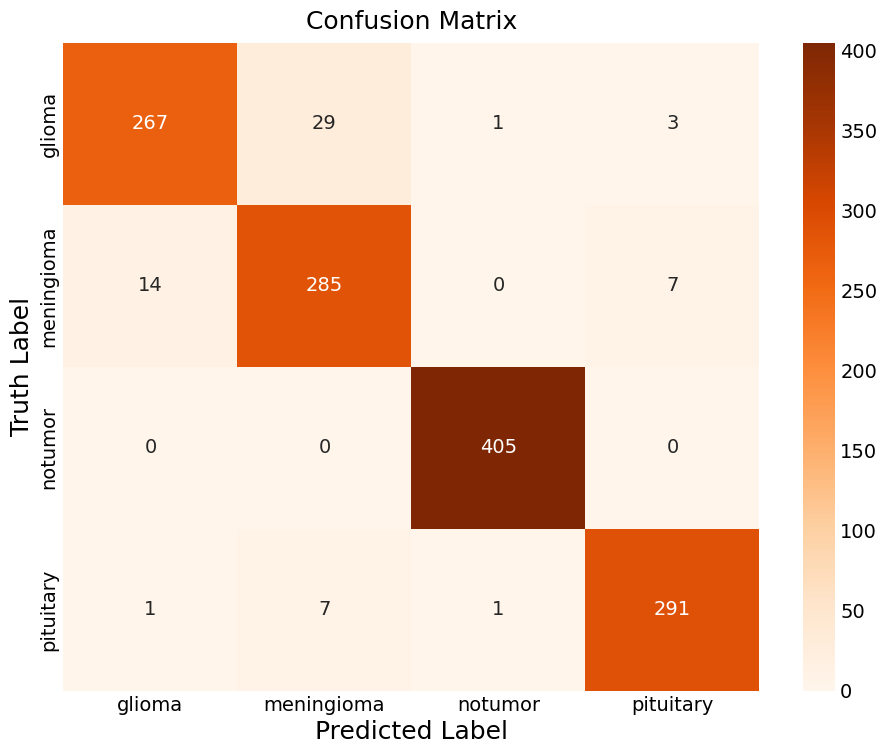

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Model predictions
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
class_dir = train_generator.class_indices
classes = list(class_dir.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
labels = list(class_dir.keys())

# Plot with white background and color bar
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Oranges',
    xticklabels=labels, yticklabels=labels,
    ax=ax, cbar=True  # Show color bar
)
ax.set_xlabel('Predicted Label',fontsize=18, color='black')
ax.set_ylabel('Truth Label',fontsize=18, color='black')
ax.set_title('Confusion Matrix',fontsize=18, color='black', pad=10)
ax.set_facecolor('white')  # Ensure axes background is white
plt.show()

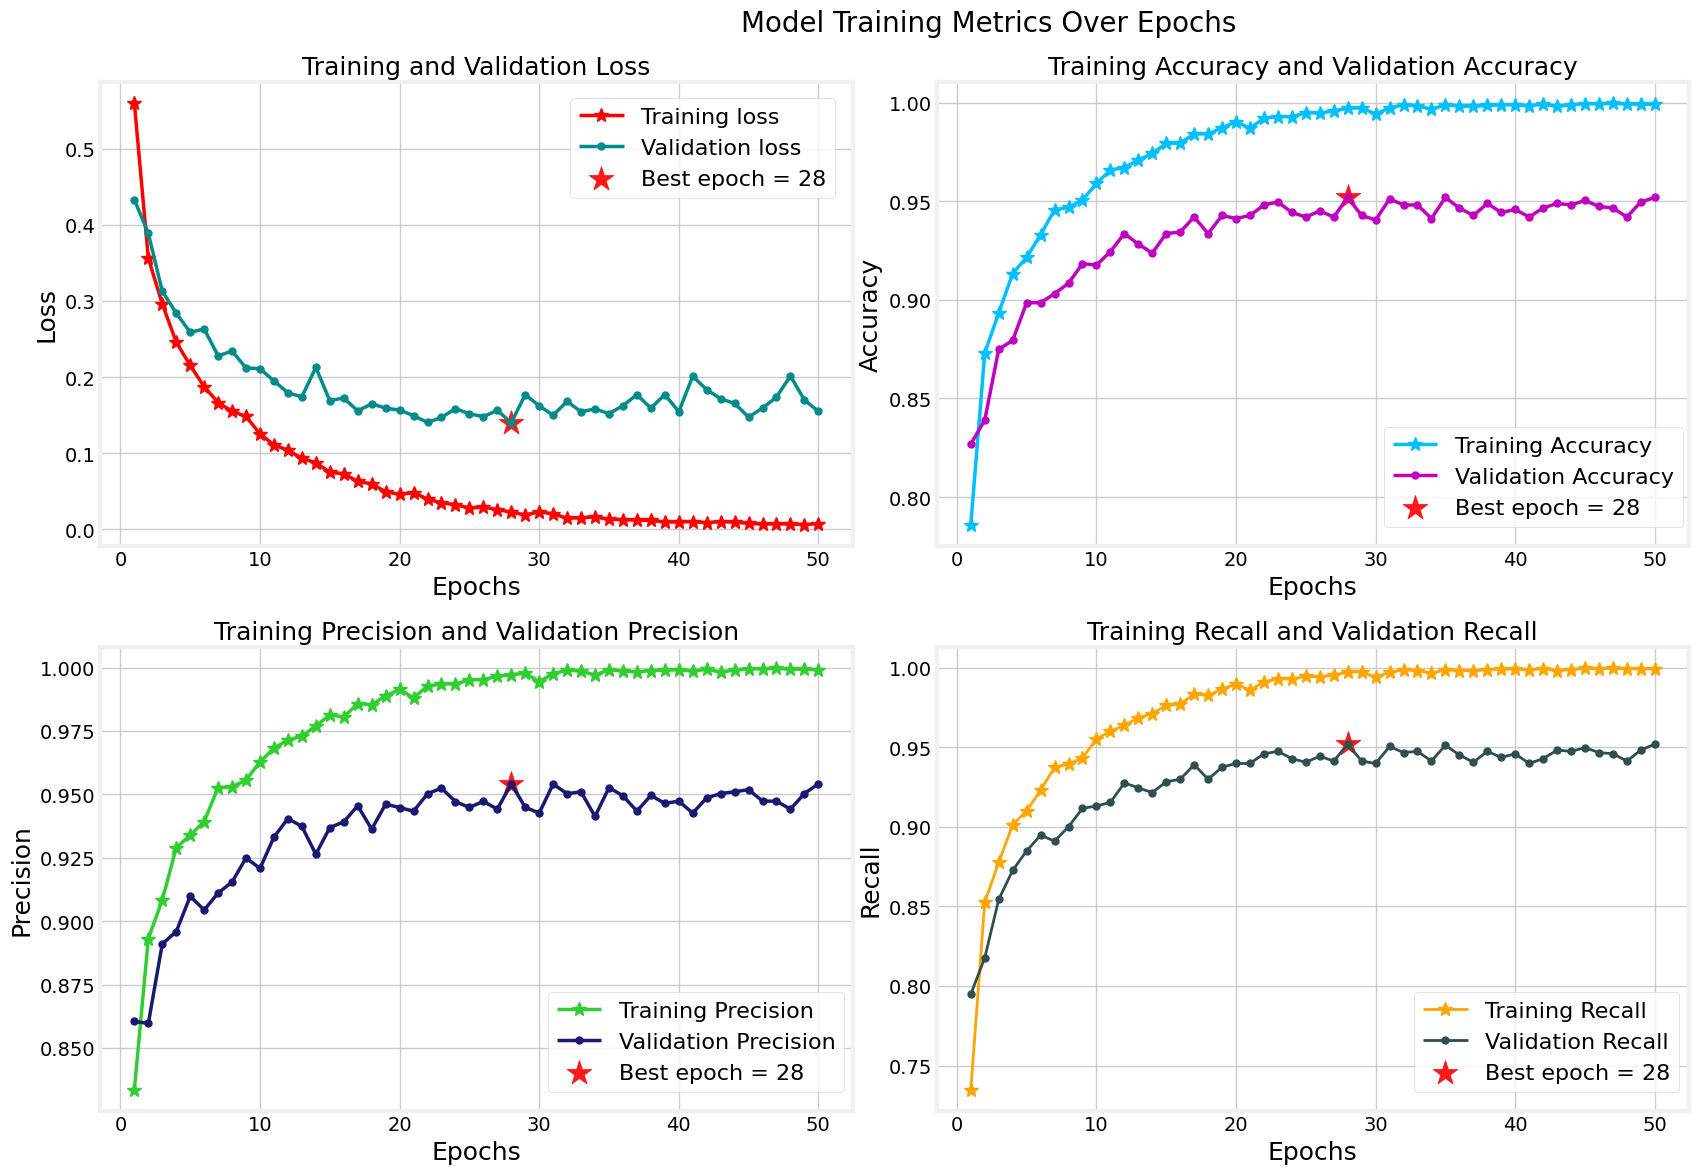

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'history' object is already available and contains the model training history
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision_2']
tr_recall = hist.history['recall_2']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision_2']
val_recall = hist.history['val_recall_2']

# Best epoch calculations
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

# Create a figure with a white background
plt.figure(figsize=(20, 12), facecolor='white')

# First subplot (Training and Validation Loss)
plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss', marker='*', linestyle='-', markersize=10, linewidth=2.5)
plt.plot(Epochs, val_loss, 'darkcyan', label='Validation loss', marker='.', linestyle='-', markersize=10, linewidth=2.5)
plt.scatter(index_loss + 1, val_lowest, s=350, c='red', marker='*', alpha=0.9, label=loss_label)
plt.title('Training and Validation Loss', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Loss', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.61, 0.99))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Second subplot (Training and Validation Accuracy)
plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'deepskyblue', label='Training Accuracy', marker='*', linestyle='-', markersize=10, linewidth=2.5)
plt.plot(Epochs, val_acc, 'm', label='Validation Accuracy', marker='.', linestyle='-', markersize=10, linewidth=2.5)
plt.scatter(index_acc + 1, acc_highest, s=350, c='red', marker='*', alpha=0.9, label=acc_label)
plt.title('Training Accuracy and Validation Accuracy', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Accuracy', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.58, 0.28))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Third subplot (Training and Validation Precision)
plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'limegreen', label='Training Precision', marker='*', linestyle='-', markersize=10, linewidth=2.5)
plt.plot(Epochs, val_per, 'midnightblue', label='Validation Precision', marker='.', linestyle='-', markersize=10, linewidth=2.5)
plt.scatter(index_precision + 1, per_highest, s=350, c='red', marker='*', alpha=0.9, label=per_label)
plt.title('Training Precision and Validation Precision', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Precision', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.58, 0.28))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Fourth subplot (Training and Validation Recall)
plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'orange', label='Training Recall', marker='*', linestyle='-', markersize=10, linewidth=2)
plt.plot(Epochs, val_recall, 'darkslategray', label='Validation Recall', marker='.', linestyle='-', markersize=10, linewidth=2)
plt.scatter(index_recall + 1, recall_highest, s=350, c='red', marker='*', alpha=0.9, label=recall_label)
plt.title('Training Recall and Validation Recall', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Recall', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.62, 0.28))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Set the overall title and display the figure
plt.suptitle('Model Training Metrics Over Epochs', fontsize=20, color='black')
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Adjust the space for the legend
plt.show()

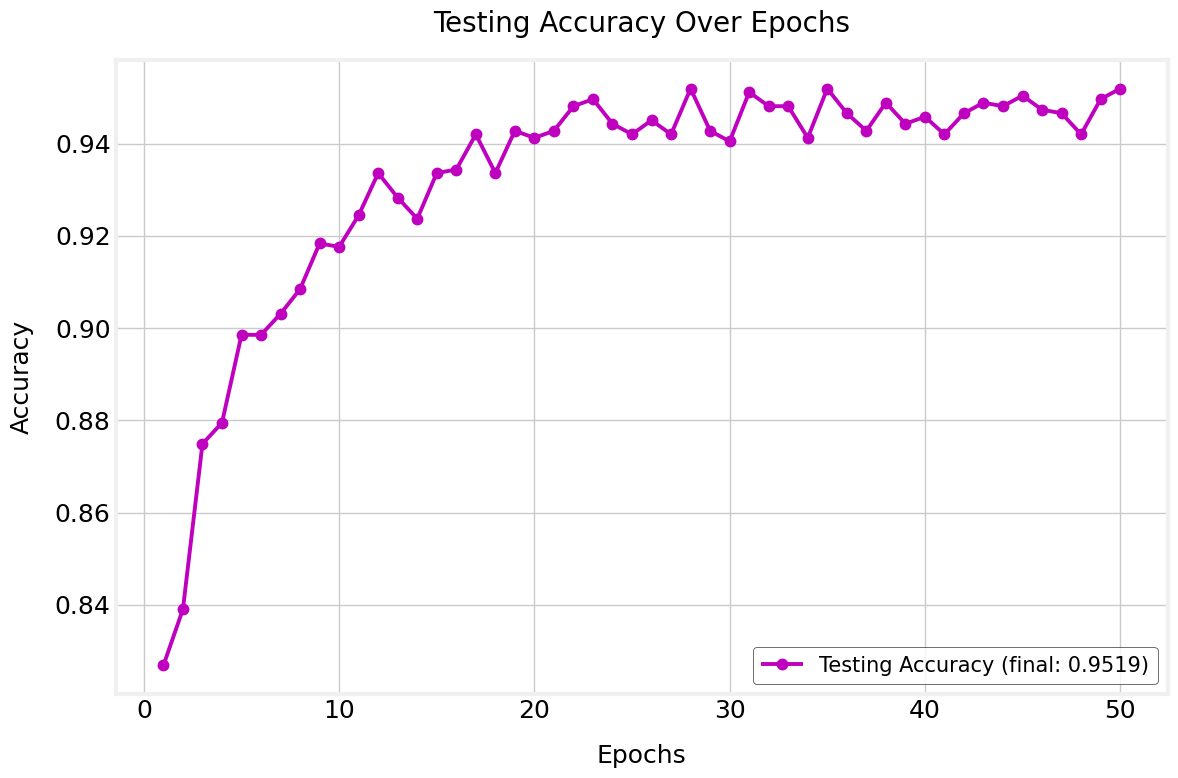

In [117]:
import matplotlib.pyplot as plt

# Assuming you have these in your history object:
train_acc = hist.history['accuracy']
test_acc = hist.history['val_accuracy']
epochs_range = range(1, len(train_acc) + 1)

final_test_acc = test_acc[-1]

plt.figure(figsize=(12, 8), facecolor='white')
plt.style.use('fivethirtyeight')


# Testing accuracy: orange stars
plt.plot(
    epochs_range, test_acc, color='m', marker='.', linestyle='-', 
    linewidth=2.8, markersize=13, markerfacecolor='m', markeredgewidth=2, 
    label=f'Testing Accuracy (final: {final_test_acc:.4f})'
)

plt.title('Testing Accuracy Over Epochs', fontsize=20, color='black', pad=20)
plt.xlabel('Epochs', fontsize=18, color='black', labelpad=15)
plt.ylabel('Accuracy', fontsize=18, color='black', labelpad=15)

# Set tick labels to black and larger
plt.xticks(fontsize=18, color='black')
plt.yticks(fontsize=18, color='black')

# Legend: larger and black text
plt.legend(fontsize=15, frameon=True, facecolor='white', edgecolor='black', loc='lower right')

plt.gca().set_facecolor('white')
plt.grid(True)
plt.tight_layout()
plt.show()

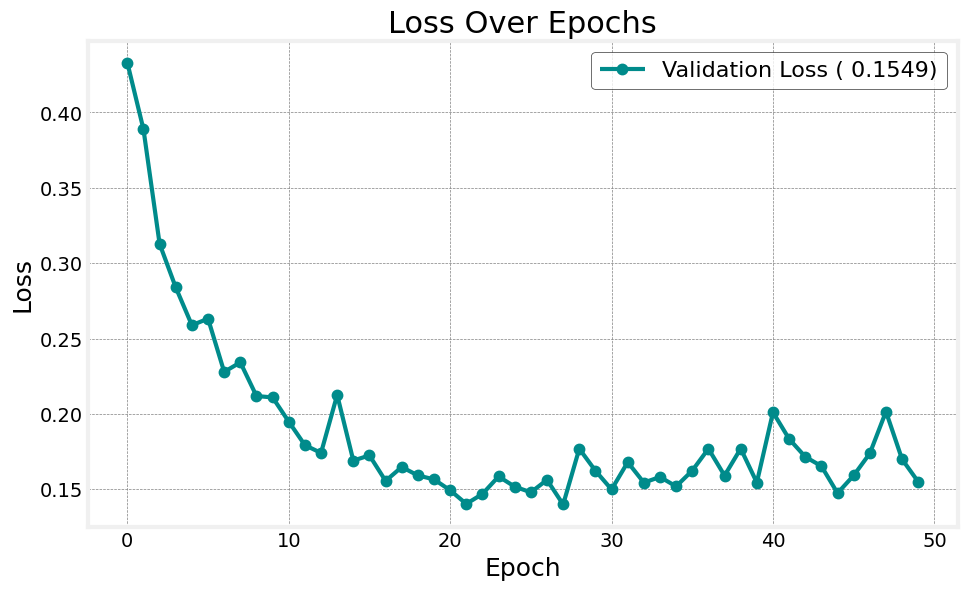

In [122]:
last_val_loss = hist.history['val_loss'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(hist.history['val_loss'], 
         label=f'Validation Loss ( {last_val_loss:.4f})', 
         color='darkcyan', marker='.', linestyle='-', markersize=13, markerfacecolor='darkcyan', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Loss', fontsize=18, color='black')
plt.title('Loss Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

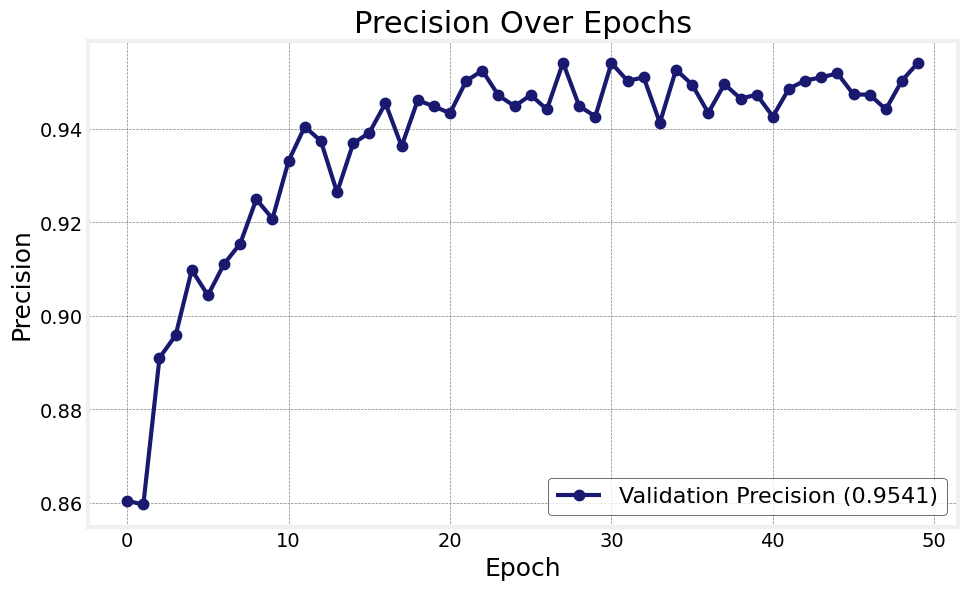

In [123]:
last_val_precision = hist.history['val_precision_2'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(hist.history['val_precision_2'], 
         label=f'Validation Precision ({last_val_precision:.4f})', 
         color='midnightblue', marker='.', linestyle='-', markersize=13, markerfacecolor='midnightblue', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Precision', fontsize=18, color='black')
plt.title('Precision Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

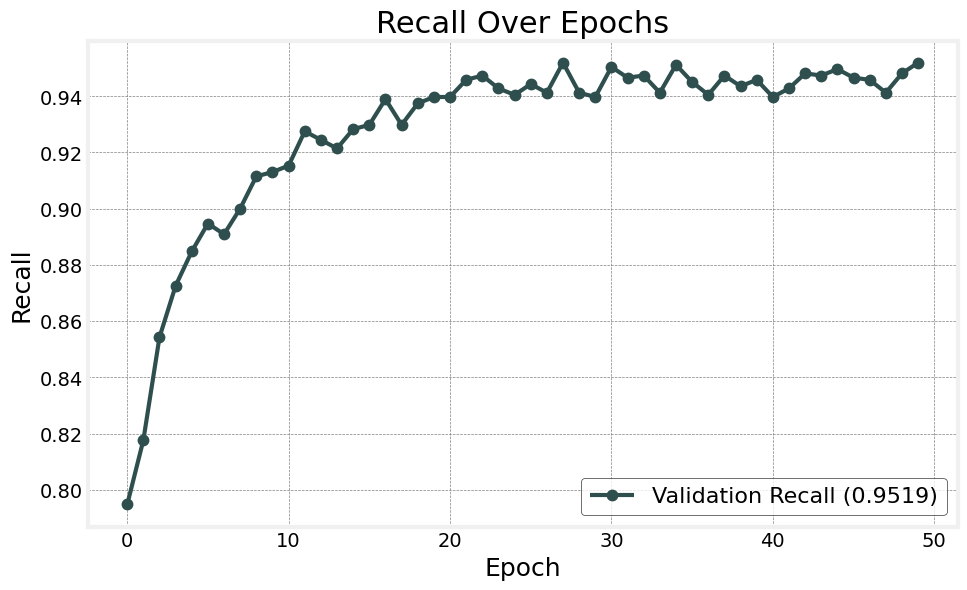

In [171]:
# Get the last value of validation recall
last_val_recall = hist.history['val_recall_2'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(hist.history['val_recall_2'], 
         label=f'Validation Recall ({last_val_recall:.4f})', 
         color='darkslategray', marker='.', linestyle='-', markersize=13, markerfacecolor='darkslategray', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Recall', fontsize=18, color='black')
plt.title('Recall Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

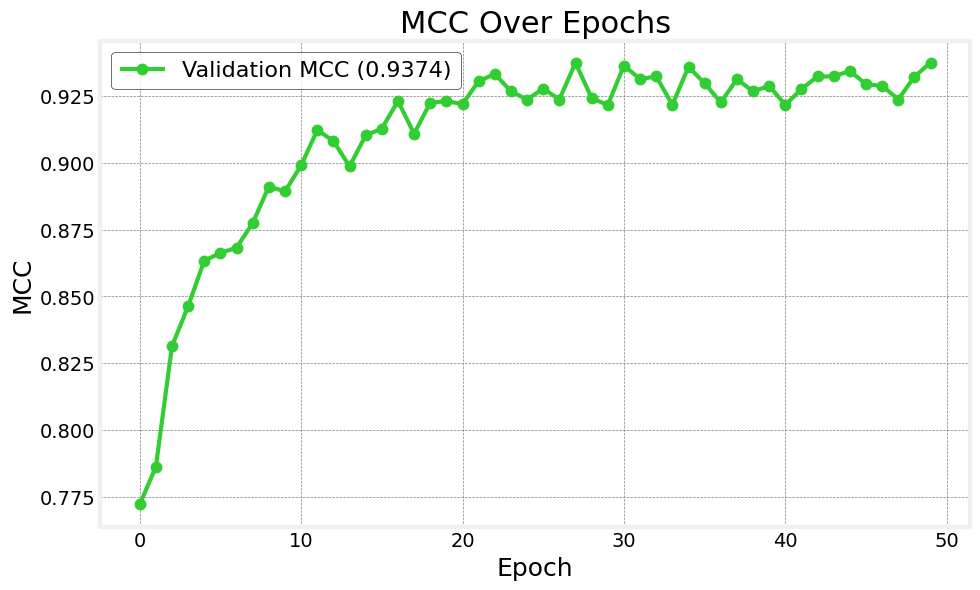

In [127]:
last_val_mcc = hist.history['val_matthews_correlation'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(hist.history['val_matthews_correlation'], 
         label=f'Validation MCC ({last_val_mcc:.4f})', 
         color='limegreen', marker='.', linestyle='-', markersize=13, markerfacecolor='limegreen', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('MCC', fontsize=18, color='black')
plt.title('MCC Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

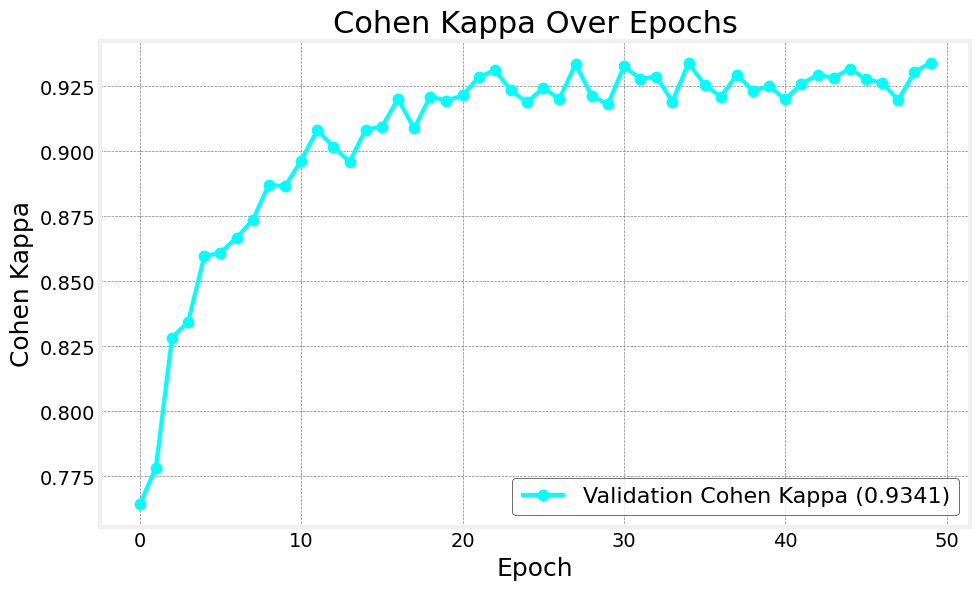

In [176]:
# Get the last value of validation Cohen Kappa
last_val_kappa = hist.history['val_cohen_kappa'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(hist.history['val_cohen_kappa'], 
         label=f'Validation Cohen Kappa ({last_val_kappa:.4f})', 
         color='aqua', marker='.', linestyle='-', markersize=13, markerfacecolor='aqua', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Cohen Kappa', fontsize=18, color='black')
plt.title('Cohen Kappa Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

41/41 [==============================] - 2s 41ms/step


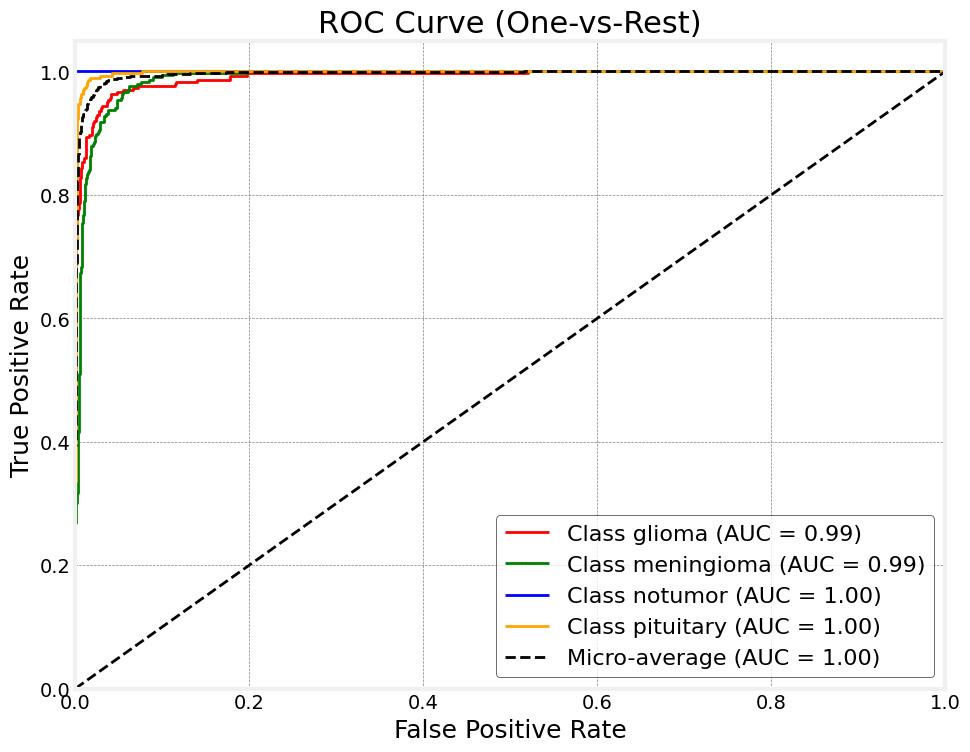

In [113]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get true labels and predicted probabilities
test_steps = test_generator.samples // test_generator.batch_size + 1
y_score = model.predict(test_generator, steps=test_steps)
y_true = test_generator.classes
n_classes = y_score.shape[1]

# Binarize the true labels for ROC
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot
plt.figure(figsize=(10, 8), facecolor='white')
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
class_names = list(test_generator.class_indices.keys())

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--', lw=2,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18, color='black')
plt.ylabel('True Positive Rate', fontsize=18, color='black')
plt.title('ROC Curve (One-vs-Rest)', fontsize=22, color='black')
plt.legend(loc="lower right", facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [133]:
#######################################################################################################################################################

Xception

In [139]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall, AUC, RootMeanSquaredError
import tensorflow.keras.backend as K
from tensorflow.keras.applications import Xception  # Changed here
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, jaccard_score, r2_score

# Define custom metrics
def matthews_correlation_a(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon())

def cohen_kappa_a(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)
    confusion = tf.math.confusion_matrix(y_true, y_pred, num_classes=4)
    n = K.sum(confusion)
    sum_po = K.sum(tf.linalg.diag_part(confusion))
    po = sum_po / n
    pe = K.sum(K.sum(confusion, axis=0) * K.sum(confusion, axis=1)) / (n * n)
    return (po - pe) / (1 - pe + K.epsilon())

def jaccard_index_a(y_true, y_pred):
    y_pred = K.round(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1])
    jac = (intersection + K.epsilon()) / (sum_ - intersection + K.epsilon())
    return K.mean(jac)

def r2_score_a(y_true, y_pred):
    ss_res =  K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

def logcosh_a(y_true, y_pred):
    return K.mean(tf.math.log(tf.math.cosh(y_pred - y_true)))

# Load Xception base model
base_model_a = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model_a.layers:
    layer.trainable = False

# Add custom layers
x = base_model_a.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(4, activation='softmax')(x)

# Create the model
modela = Model(inputs=base_model_a.input, outputs=x)

# Compile the model with custom metrics
modela.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(),
        'mae',
        'mse',
        RootMeanSquaredError(),
        matthews_correlation_a,
        cohen_kappa_a,
        jaccard_index_a,
        r2_score_a,
        logcosh_a
    ]
)

# Print the model summary
modela.summary()
print(f"Total params: {modela.count_params()}")

# Data generators (replace with your own)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_a = ImageDataGenerator(rescale=1./255)
val_datagen_a = ImageDataGenerator(rescale=1./255)

# <<<<<<<<<<< REPLACE THESE PATHS WITH YOUR ACTUAL DATA FOLDERS >>>>>>>>>>
train_dir_a = r'D:/BRAIN DATA/bt mri 7023/training'  # e.g. r'C:/Users/YourName/data/train'
val_dir_a = r'D:/BRAIN DATA/bt mri 7023/testing'      # e.g. r'C:/Users/YourName/data/val'
train_generator_a = train_datagen_a.flow_from_directory(
    train_dir_a,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator_a = val_datagen_a.flow_from_directory(
    val_dir_a,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [140]:
# Train the model
hista = modela.fit(
    train_generator_a,
    epochs=50,
    validation_data=val_generator_a
)

Epoch 1/50
179/179 [==============================] - 14s 65ms/step - loss: 0.5330 - accuracy: 0.7988 - precision_5: 0.8566 - recall_5: 0.7323 - auc_5: 0.9530 - mae: 0.1577 - mse: 0.0719 - root_mean_squared_error: 0.2682 - matthews_correlation_a: 0.7261 - cohen_kappa_a: 0.7252 - jaccard_index_a: 0.7322 - r2_score_a: 0.6162 - logcosh_a: 0.0337 - val_loss: 0.3907 - val_accuracy: 0.8558 - val_precision_5: 0.8888 - val_recall_5: 0.8169 - val_auc_5: 0.9751 - val_mae: 0.1210 - val_mse: 0.0528 - val_root_mean_squared_error: 0.2298 - val_matthews_correlation_a: 0.8057 - val_cohen_kappa_a: 0.8005 - val_jaccard_index_a: 0.8170 - val_r2_score_a: 0.7185 - val_logcosh_a: 0.0247
Epoch 2/50
179/179 [==============================] - 11s 60ms/step - loss: 0.3462 - accuracy: 0.8754 - precision_5: 0.9001 - recall_5: 0.8505 - auc_5: 0.9794 - mae: 0.1039 - mse: 0.0461 - root_mean_squared_error: 0.2146 - matthews_correlation_a: 0.8347 - cohen_kappa_a: 0.8296 - jaccard_index_a: 0.8504 - r2_score_a: 0.7541 -

In [142]:
train_score_a = modela.evaluate(train_generator_a, verbose=1)
valid_score_a = modela.evaluate(test_generator, verbose=1)


print(f"Train Loss: {train_score_a[0]:.4f}")
print(f"Train Accuracy: {train_score_a[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score_a[0]:.4f}")
print(f"Validation Accuracy: {valid_score_a[1]*100:.2f}%")
print('-' * 20)


41/41 [==============================] - 2s 47ms/step - loss: 0.1419 - accuracy: 0.9535 - precision_5: 0.9549 - recall_5: 0.9527 - auc_5: 0.9943 - mae: 0.0276 - mse: 0.0179 - root_mean_squared_error: 0.1337 - matthews_correlation_a: 0.9383 - cohen_kappa_a: 0.0605 - jaccard_index_a: 0.9527 - r2_score_a: 0.9046 - logcosh_a: 0.0081
Train Loss: 0.0035
Train Accuracy: 100.00%
--------------------
Validation Loss: 0.1419
Validation Accuracy: 95.35%
--------------------


41/41 [==============================] - 2s 41ms/step


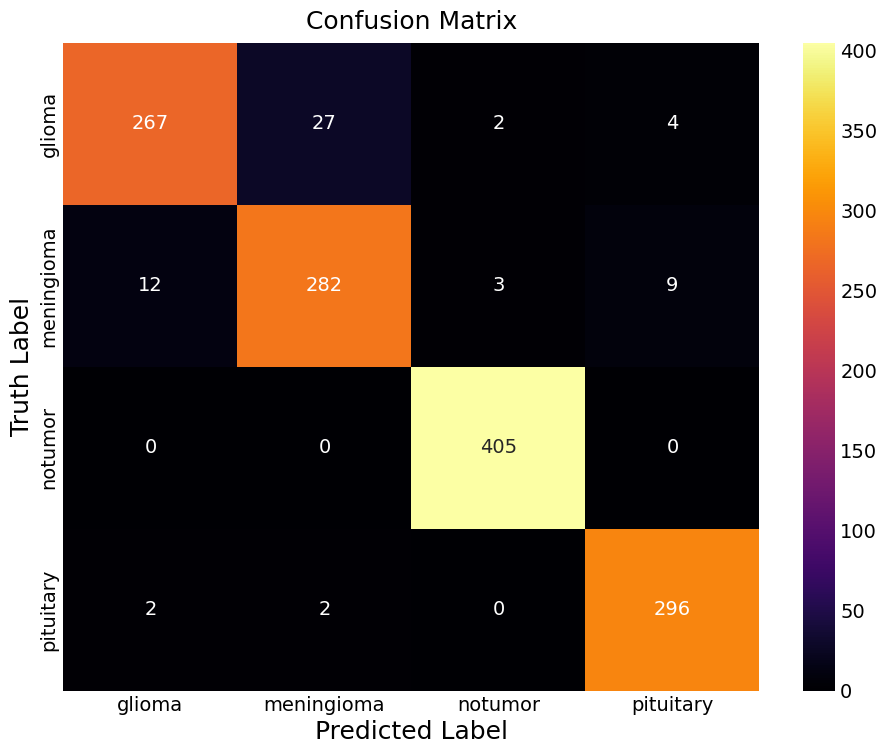

In [158]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Model predictions
preds_a = modela.predict(test_generator)
y_pred_a = np.argmax(preds_a, axis=1)
class_dir_a = train_generator_a.class_indices
classes = list(class_dir.keys())

# Confusion matrix
cm_a = confusion_matrix(test_generator.classes, y_pred_a)
labels = list(class_dir.keys())

# Plot with white background and color bar
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
sns.heatmap(
    cm_a, annot=True, fmt='d', cmap='inferno',
    xticklabels=labels, yticklabels=labels,
    ax=ax, cbar=True  # Show color bar
)
ax.set_xlabel('Predicted Label',fontsize=18, color='black')
ax.set_ylabel('Truth Label',fontsize=18, color='black')
ax.set_title('Confusion Matrix',fontsize=18, color='black', pad=10)
ax.set_facecolor('white')  # Ensure axes background is white
plt.show()

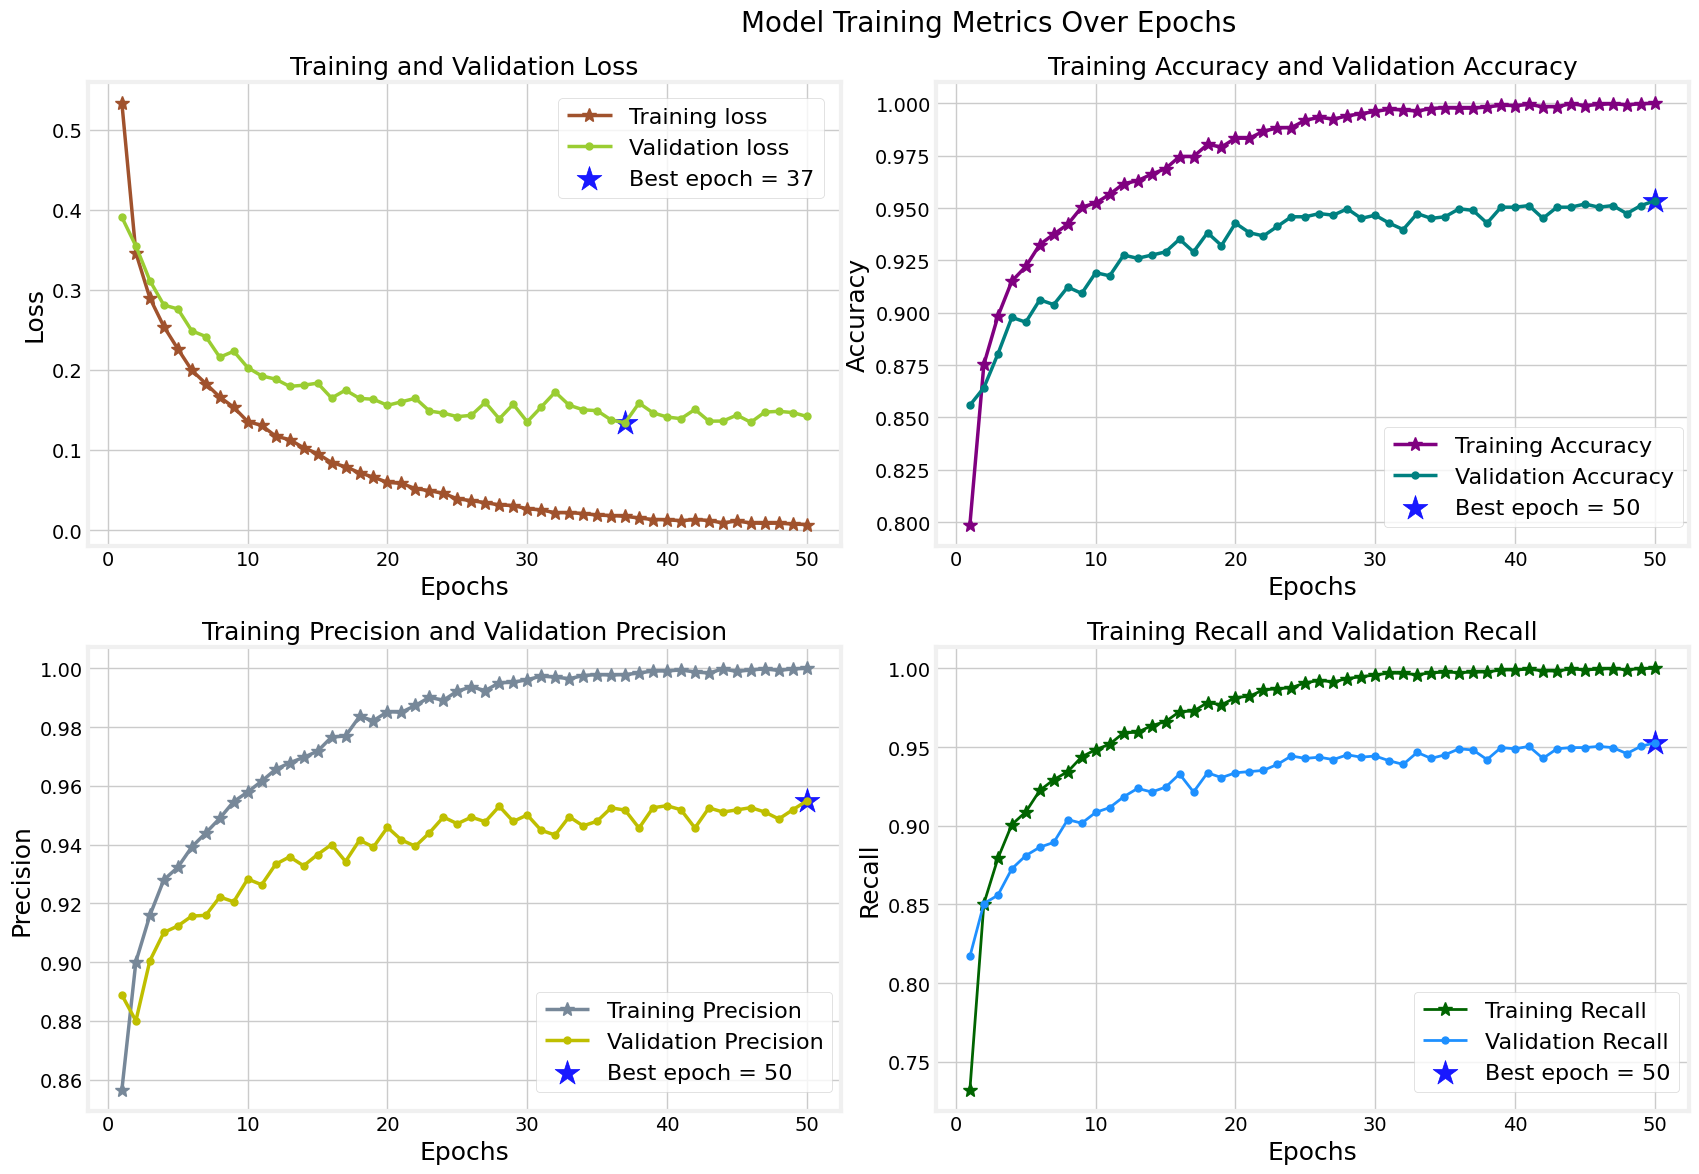

In [162]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'history' object is already available and contains the model training history
tr_acc_a = hista.history['accuracy']
tr_loss_a = hista.history['loss']
tr_per_a = hista.history['precision_5']
tr_recall_a = hista.history['recall_5']
val_acc_a = hista.history['val_accuracy']
val_loss_a = hista.history['val_loss']
val_per_a = hista.history['val_precision_5']
val_recall_a = hista.history['val_recall_5']

# Best epoch calculations
index_loss_a = np.argmin(val_loss_a)
val_lowest_a = val_loss_a[index_loss_a]
index_acc_a = np.argmax(val_acc_a)
acc_highest_a = val_acc_a[index_acc_a]
index_precision_a = np.argmax(val_per_a)
per_highest_a = val_per_a[index_precision_a]
index_recall_a = np.argmax(val_recall_a)
recall_highest_a = val_recall_a[index_recall_a]

Epochs = [i + 1 for i in range(len(tr_acc_a))]
loss_label_a = f'Best epoch = {str(index_loss_a + 1)}'
acc_label_a = f'Best epoch = {str(index_acc_a + 1)}'
per_label_a = f'Best epoch = {str(index_precision_a + 1)}'
recall_label_a = f'Best epoch = {str(index_recall_a + 1)}'

# Create a figure with a white background
plt.figure(figsize=(20, 12), facecolor='white')

# First subplot (Training and Validation Loss)
plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss_a, 'sienna', label='Training loss', marker='*', linestyle='-', markersize=10, linewidth=2.5)
plt.plot(Epochs, val_loss_a, 'yellowgreen', label='Validation loss', marker='.', linestyle='-', markersize=10, linewidth=2.5)
plt.scatter(index_loss_a + 1, val_lowest_a, s=350, c='b', marker='*', alpha=0.9, label=loss_label_a)
plt.title('Training and Validation Loss', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Loss', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.61, 0.99))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Second subplot (Training and Validation Accuracy)
plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc_a, 'purple', label='Training Accuracy', marker='*', linestyle='-', markersize=10, linewidth=2.5)
plt.plot(Epochs, val_acc_a, 'teal', label='Validation Accuracy', marker='.', linestyle='-', markersize=10, linewidth=2.5)
plt.scatter(index_acc_a + 1, acc_highest_a, s=350, c='b', marker='*', alpha=0.9, label=acc_label_a)
plt.title('Training Accuracy and Validation Accuracy', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Accuracy', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.58, 0.28))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Third subplot (Training and Validation Precision)
plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per_a, 'lightslategray', label='Training Precision', marker='*', linestyle='-', markersize=10, linewidth=2.5)
plt.plot(Epochs, val_per_a, 'y', label='Validation Precision', marker='.', linestyle='-', markersize=10, linewidth=2.5)
plt.scatter(index_precision_a + 1, per_highest_a, s=350, c='b', marker='*', alpha=0.9, label=per_label_a)
plt.title('Training Precision and Validation Precision', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Precision', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.58, 0.28))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Fourth subplot (Training and Validation Recall)
plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall_a, 'darkgreen', label='Training Recall', marker='*', linestyle='-', markersize=10, linewidth=2)
plt.plot(Epochs, val_recall_a, 'dodgerblue', label='Validation Recall', marker='.', linestyle='-', markersize=10, linewidth=2)
plt.scatter(index_recall_a + 1, recall_highest_a, s=350, c='b', marker='*', alpha=0.9, label=recall_label_a)
plt.title('Training Recall and Validation Recall', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Recall', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.62, 0.28))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Set the overall title and display the figure
plt.suptitle('Model Training Metrics Over Epochs', fontsize=20, color='black')
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Adjust the space for the legend
plt.show()

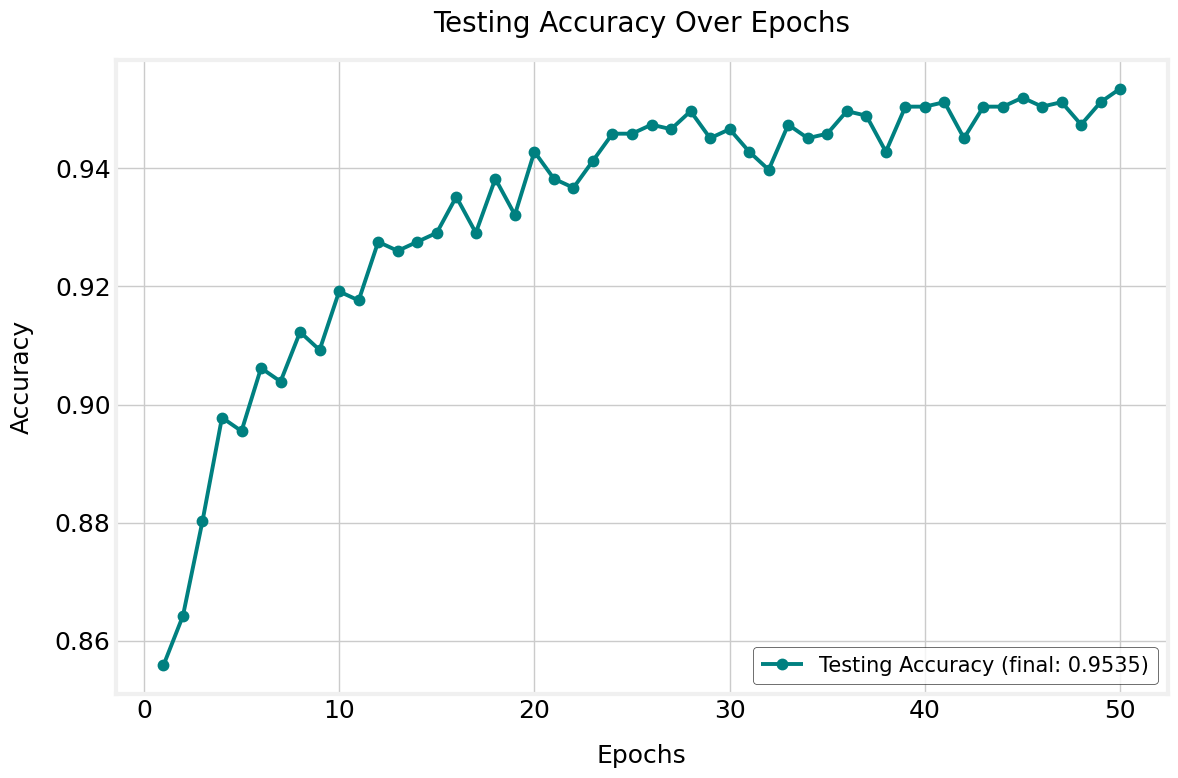

In [164]:
import matplotlib.pyplot as plt

# Assuming you have these in your history object:
train_acc_a = hista.history['accuracy']
test_acc_a = hista.history['val_accuracy']
epochs_range = range(1, len(train_acc_a) + 1)

final_test_acc_a = test_acc_a[-1]

plt.figure(figsize=(12, 8), facecolor='white')
plt.style.use('fivethirtyeight')


# Testing accuracy: orange stars
plt.plot(
    epochs_range, test_acc_a, color='teal', marker='.', linestyle='-', 
    linewidth=2.8, markersize=13, markerfacecolor='teal', markeredgewidth=2, 
    label=f'Testing Accuracy (final: {final_test_acc_a:.4f})'
)

plt.title('Testing Accuracy Over Epochs', fontsize=20, color='black', pad=20)
plt.xlabel('Epochs', fontsize=18, color='black', labelpad=15)
plt.ylabel('Accuracy', fontsize=18, color='black', labelpad=15)

# Set tick labels to black and larger
plt.xticks(fontsize=18, color='black')
plt.yticks(fontsize=18, color='black')

# Legend: larger and black text
plt.legend(fontsize=15, frameon=True, facecolor='white', edgecolor='black', loc='lower right')

plt.gca().set_facecolor('white')
plt.grid(True)
plt.tight_layout()
plt.show()

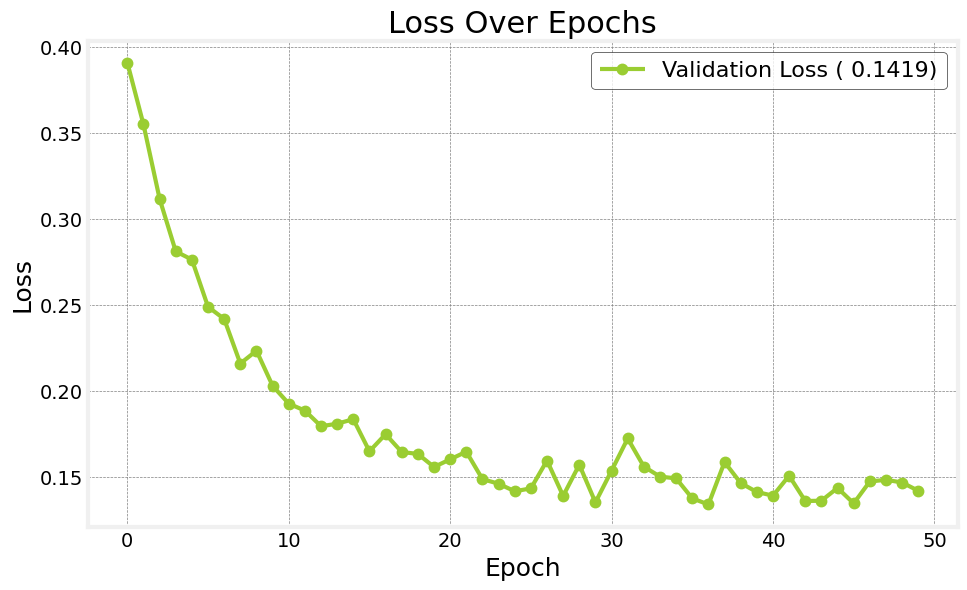

In [166]:
last_val_loss_a = hista.history['val_loss'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(hista.history['val_loss'], 
         label=f'Validation Loss ( {last_val_loss_a:.4f})', 
         color='yellowgreen', marker='.', linestyle='-', markersize=13, markerfacecolor='yellowgreen', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Loss', fontsize=18, color='black')
plt.title('Loss Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

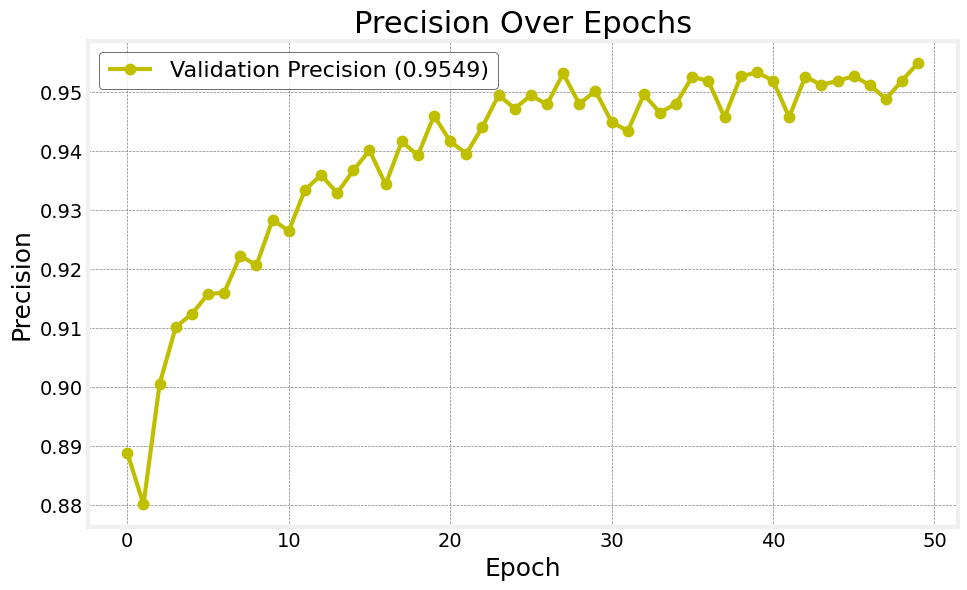

In [169]:
last_val_precision_a = hista.history['val_precision_5'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(hista.history['val_precision_5'], 
         label=f'Validation Precision ({last_val_precision_a:.4f})', 
         color='y', marker='.', linestyle='-', markersize=13, markerfacecolor='y', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Precision', fontsize=18, color='black')
plt.title('Precision Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

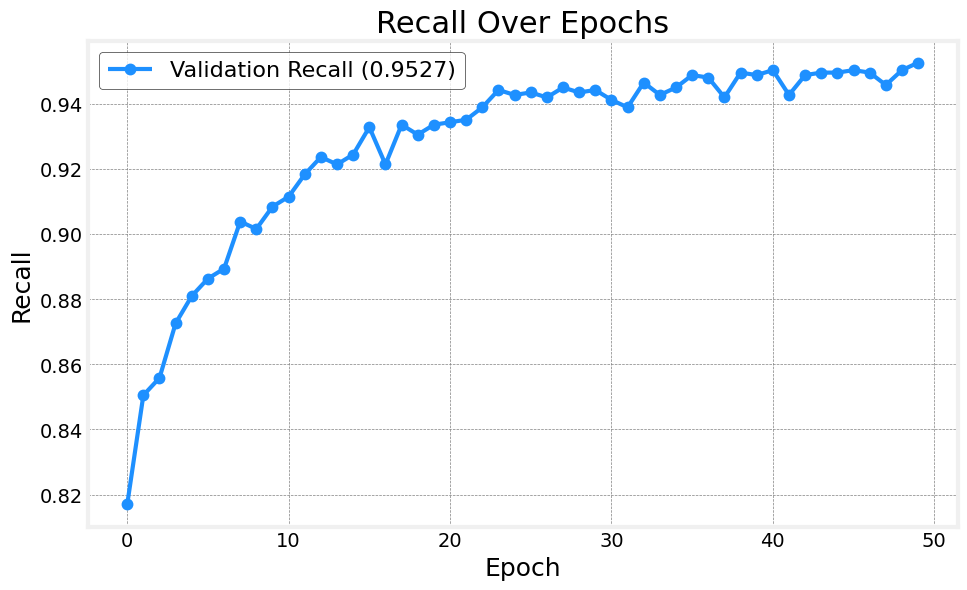

In [199]:
# Get the last value of validation recall
last_val_recall_a = hista.history['val_recall_5'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(hista.history['val_recall_5'], 
         label=f'Validation Recall ({last_val_recall_a:.4f})', 
         color='dodgerblue', marker='.', linestyle='-', markersize=13, markerfacecolor='dodgerblue', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Recall', fontsize=18, color='black')
plt.title('Recall Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

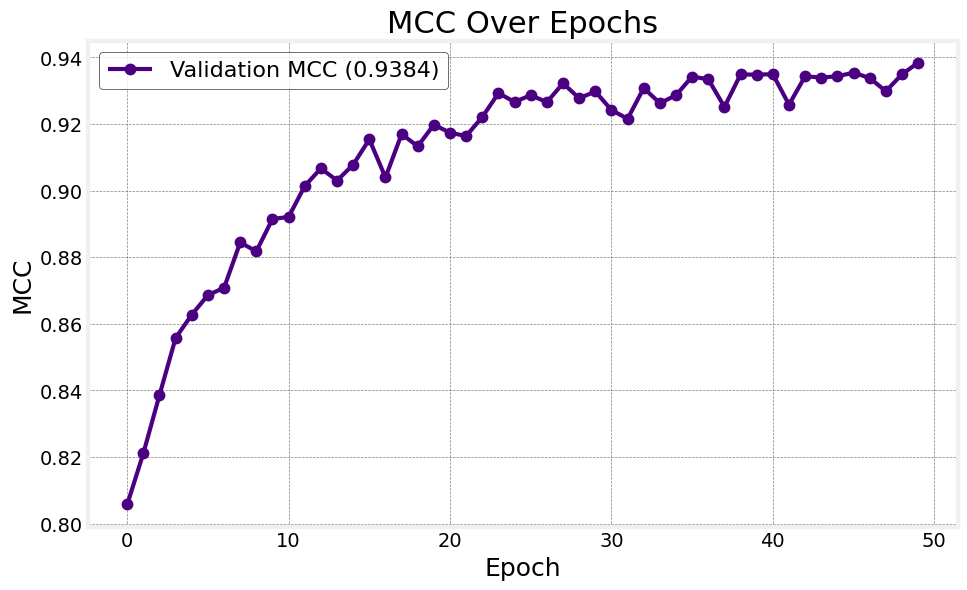

In [200]:
last_val_mcc_a = hista.history['val_matthews_correlation_a'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(hista.history['val_matthews_correlation_a'], 
         label=f'Validation MCC ({last_val_mcc_a:.4f})', 
         color='indigo', marker='.', linestyle='-', markersize=13, markerfacecolor='indigo', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('MCC', fontsize=18, color='black')
plt.title('MCC Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

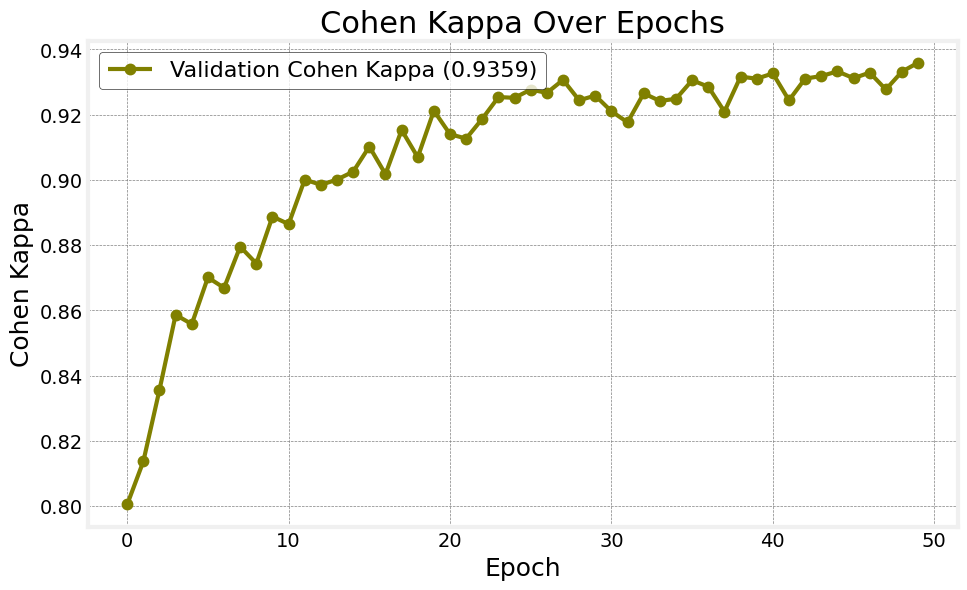

In [175]:
# Get the last value of validation Cohen Kappa
last_val_kappa_a = hista.history['val_cohen_kappa_a'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(hista.history['val_cohen_kappa_a'], 
         label=f'Validation Cohen Kappa ({last_val_kappa_a:.4f})', 
         color='olive', marker='.', linestyle='-', markersize=13, markerfacecolor='olive', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Cohen Kappa', fontsize=18, color='black')
plt.title('Cohen Kappa Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

41/41 [==============================] - 5s 116ms/step


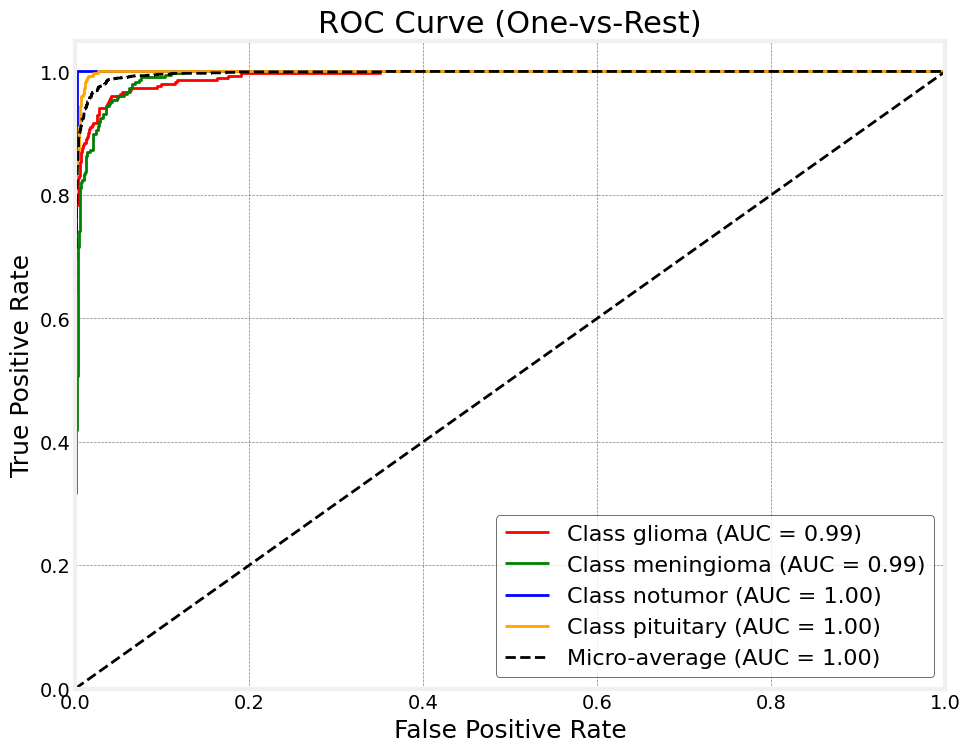

In [183]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get true labels and predicted probabilities
test_steps_a = test_generator.samples // test_generator.batch_size + 1
y_score_a = modela.predict(test_generator, steps=test_steps)
y_true_a = test_generator.classes
n_classes = y_score_a.shape[1]

# Binarize the true labels for ROC
y_true_bin_a = label_binarize(y_true_a, classes=np.arange(n_classes))
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin_a[:, i], y_score_a[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin_a.ravel(), y_score_a.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot
plt.figure(figsize=(10, 8), facecolor='white')
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
class_names = list(test_generator.class_indices.keys())

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--', lw=2,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18, color='black')
plt.ylabel('True Positive Rate', fontsize=18, color='black')
plt.title('ROC Curve (One-vs-Rest)', fontsize=22, color='black')
plt.legend(loc="lower right", facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [14]:
#####################################################################################################################################################

Concatenated AlexNet+MobileNet

In [189]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Input, concatenate
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall, AUC, RootMeanSquaredError
import tensorflow.keras.backend as K
from tensorflow.keras.applications import MobileNet

# Custom metrics (as you defined)
def matthews_correlation_b(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon())

def cohen_kappa_b(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)
    confusion = tf.math.confusion_matrix(y_true, y_pred, num_classes=4)
    n = K.sum(confusion)
    sum_po = K.sum(tf.linalg.diag_part(confusion))
    po = sum_po / n
    pe = K.sum(K.sum(confusion, axis=0) * K.sum(confusion, axis=1)) / (n * n)
    return (po - pe) / (1 - pe + K.epsilon())

def jaccard_index_b(y_true, y_pred):
    y_pred = K.round(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1])
    jac = (intersection + K.epsilon()) / (sum_ - intersection + K.epsilon())
    return K.mean(jac)

def r2_score_b(y_true, y_pred):
    ss_res =  K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

def logcosh_b(y_true, y_pred):
    return K.mean(tf.math.log(tf.math.cosh(y_pred - y_true)))

# AlexNet block
def AlexNet_block(input_tensor):
    x = Conv2D(96, (11, 11), strides=4, activation='relu', padding='same')(input_tensor)
    x = MaxPooling2D((3, 3), strides=2)(x)
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)
    x = GlobalAveragePooling2D()(x)
    return x

# MobileNet block
def MobileNet_block(input_tensor):
    mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in mobilenet_base.layers:
        layer.trainable = False
    x = mobilenet_base.output
    x = GlobalAveragePooling2D()(x)
    return x

# Input
input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape)

# Feature extraction
alexnet_features = AlexNet_block(input_tensor)
mobilenet_features = MobileNet_block(input_tensor)

# Concatenate
combined = concatenate([alexnet_features, mobilenet_features])

# Dense layers
x = Dense(128, activation='relu')(combined)
x = Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)

# Model
modelb = Model(inputs=input_tensor, outputs=output)

# Compile
modelb.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(),
        'mae',
        'mse',
        RootMeanSquaredError(),
        matthews_correlation_b,
        cohen_kappa_b,
        jaccard_index_b,
        r2_score_b,
        logcosh_b
    ]
)

modelb.summary()
print(f"Total params: {modelb.count_params()}")

#
# Data generators
train_datagen_b = ImageDataGenerator(rescale=1./255)
val_datagen_b = ImageDataGenerator(rescale=1./255)

# <<<<<<<<<<< REPLACE THESE PATHS WITH YOUR ACTUAL DATA FOLDERS >>>>>>>>>>
train_dir_b = r'D:/BRAIN DATA/bt mri 7023/training'  # e.g. r'C:/Users/YourName/data/train'
val_dir_b = r'D:/BRAIN DATA/bt mri 7023/testing'      # e.g. r'C:/Users/YourName/data/val'

train_generator_b = train_datagen_b.flow_from_directory(
    train_dir_b,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator_b = val_datagen_b.flow_from_directory(
    val_dir_b,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

In [190]:
# Train
histb = modelb.fit(
    train_generator_b,
    epochs=50,
    validation_data=val_generator_b
)

Epoch 1/50
179/179 [==============================] - 26s 131ms/step - loss: 0.4904 - accuracy: 0.8197 - precision_7: 0.8682 - recall_7: 0.7712 - auc_7: 0.9597 - mae: 0.1404 - mse: 0.0645 - root_mean_squared_error: 0.2539 - matthews_correlation_b: 0.7581 - cohen_kappa_b: 0.7534 - jaccard_index_b: 0.7711 - r2_score_b: 0.6556 - logcosh_b: 0.0302 - val_loss: 0.3425 - val_accuracy: 0.8802 - val_precision_7: 0.9019 - val_recall_7: 0.8482 - val_auc_7: 0.9795 - val_mae: 0.1003 - val_mse: 0.0460 - val_root_mean_squared_error: 0.2144 - val_matthews_correlation_b: 0.8348 - val_cohen_kappa_b: 0.8354 - val_jaccard_index_b: 0.8482 - val_r2_score_b: 0.7547 - val_logcosh_b: 0.0214
Epoch 2/50
179/179 [==============================] - 11s 60ms/step - loss: 0.2664 - accuracy: 0.9021 - precision_7: 0.9169 - recall_7: 0.8862 - auc_7: 0.9875 - mae: 0.0817 - mse: 0.0359 - root_mean_squared_error: 0.1896 - matthews_correlation_b: 0.8691 - cohen_kappa_b: 0.8651 - jaccard_index_b: 0.8860 - r2_score_b: 0.8081 

In [191]:
train_score_b = modelb.evaluate(train_generator_b, verbose=1)
valid_score_b = modelb.evaluate(test_generator, verbose=1)


print(f"Train Loss: {train_score_b[0]:.4f}")
print(f"Train Accuracy: {train_score_b[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score_b[0]:.4f}")
print(f"Validation Accuracy: {valid_score_b[1]*100:.2f}%")
print('-' * 20)


41/41 [==============================] - 2s 43ms/step - loss: 0.0898 - accuracy: 0.9756 - precision_7: 0.9756 - recall_7: 0.9756 - auc_7: 0.9954 - mae: 0.0132 - mse: 0.0095 - root_mean_squared_error: 0.0973 - matthews_correlation_b: 0.9674 - cohen_kappa_b: 0.0629 - jaccard_index_b: 0.9756 - r2_score_b: 0.9495 - logcosh_b: 0.0042
Train Loss: 0.0003
Train Accuracy: 100.00%
--------------------
Validation Loss: 0.0898
Validation Accuracy: 97.56%
--------------------


41/41 [==============================] - 2s 42ms/step


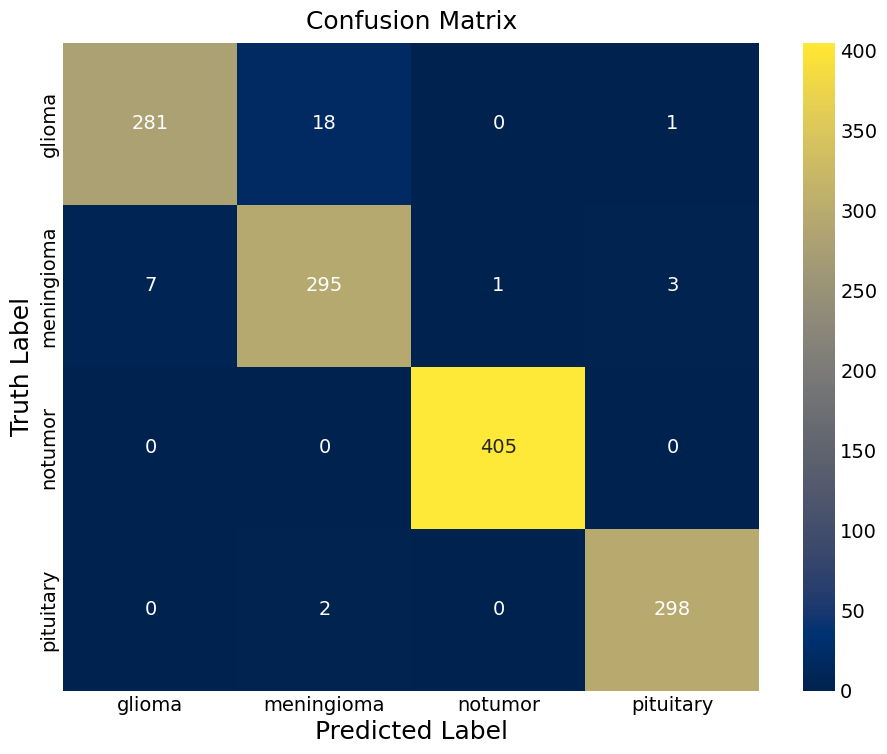

In [194]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Model predictions
preds_b = modelb.predict(test_generator)
y_pred_b = np.argmax(preds_b, axis=1)
class_dir_b = train_generator_b.class_indices
classes = list(class_dir.keys())

# Confusion matrix
cm_b = confusion_matrix(test_generator.classes, y_pred_b)
labels = list(class_dir.keys())

# Plot with white background and color bar
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
sns.heatmap(
    cm_b, annot=True, fmt='d', cmap='cividis',
    xticklabels=labels, yticklabels=labels,
    ax=ax, cbar=True  # Show color bar
)
ax.set_xlabel('Predicted Label',fontsize=18, color='black')
ax.set_ylabel('Truth Label',fontsize=18, color='black')
ax.set_title('Confusion Matrix',fontsize=18, color='black', pad=10)
ax.set_facecolor('white')  # Ensure axes background is white
plt.show()

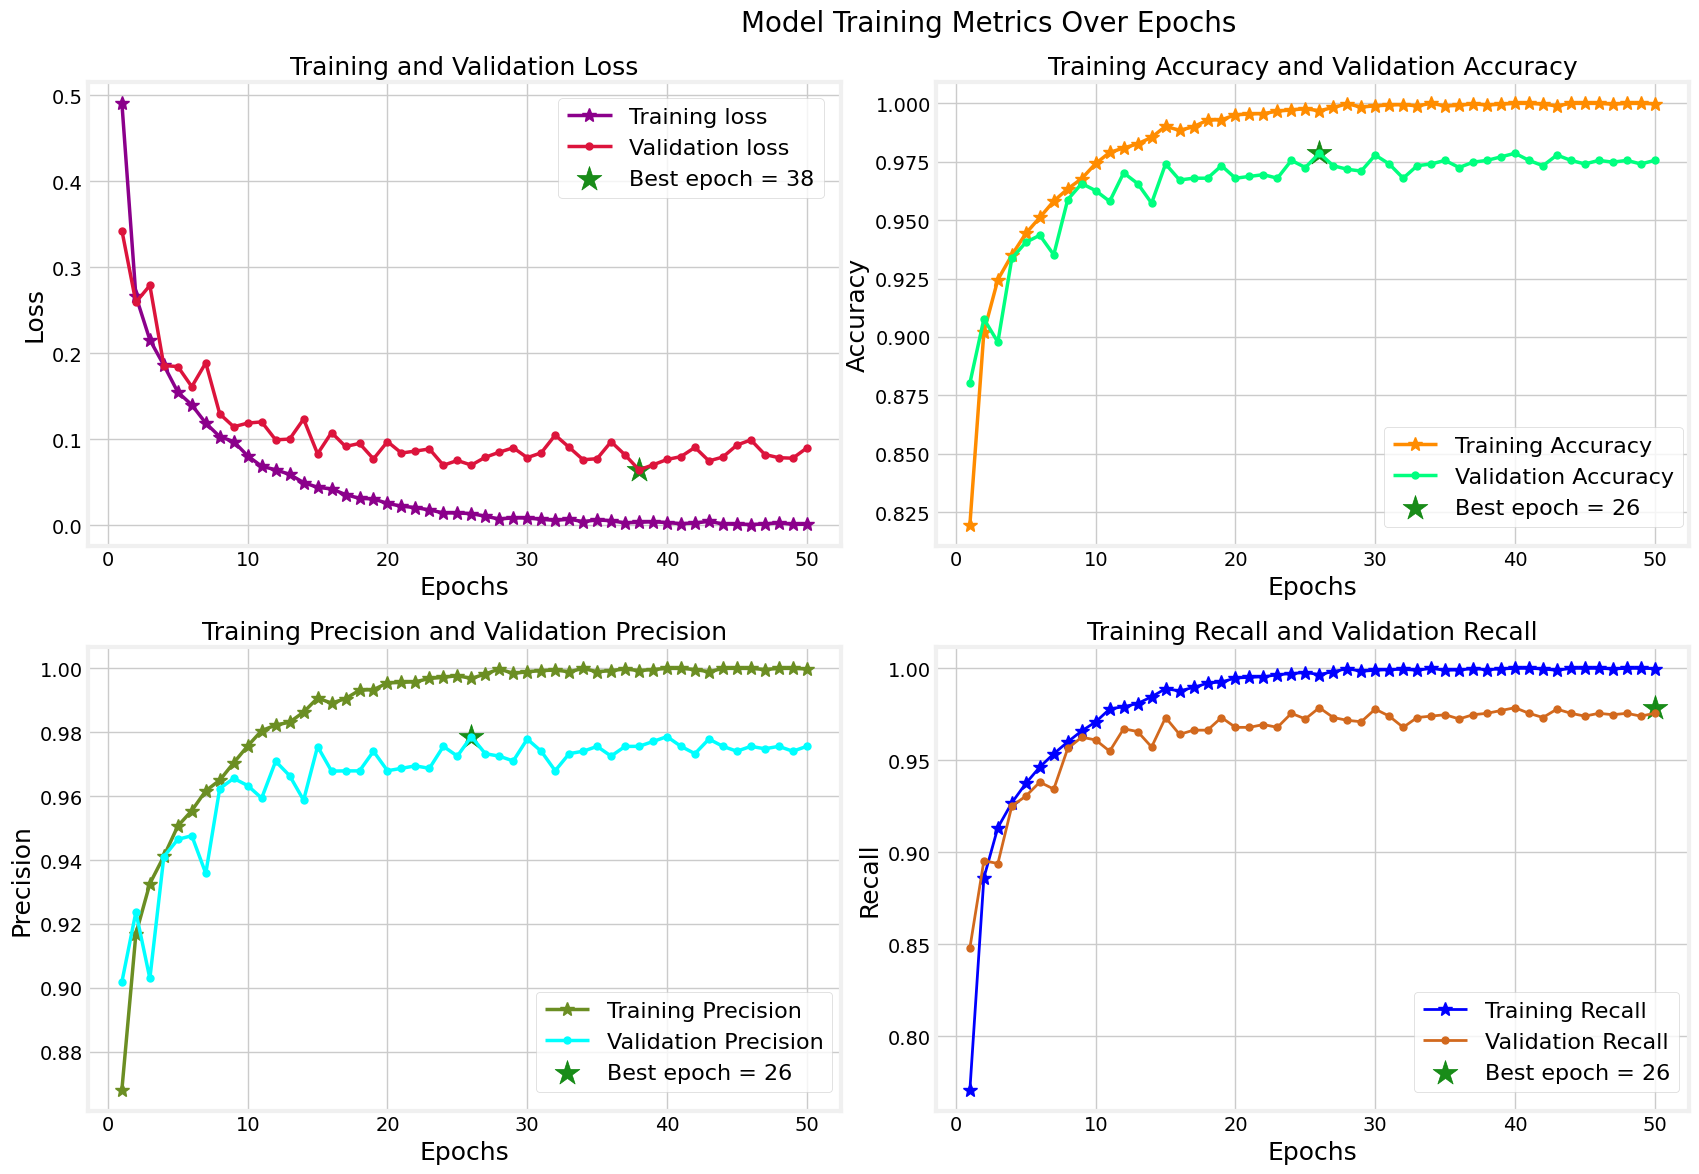

In [210]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'history' object is already available and contains the model training history
tr_acc_b = histb.history['accuracy']
tr_loss_b = histb.history['loss']
tr_per_b = histb.history['precision_7']
tr_recall_b = histb.history['recall_7']
val_acc_b = histb.history['val_accuracy']
val_loss_b = histb.history['val_loss']
val_per_b = histb.history['val_precision_7']
val_recall_b = histb.history['val_recall_7']

# Best epoch calculations
index_loss_b = np.argmin(val_loss_b)
val_lowest_b = val_loss_b[index_loss_b]
index_acc_b = np.argmax(val_acc_b)
acc_highest_b = val_acc_b[index_acc_b]
index_precision_b = np.argmax(val_per_b)
per_highest_b = val_per_b[index_precision_b]
index_recall_b = np.argmax(val_recall_b)
recall_highest_b = val_recall_b[index_recall_b]

Epochs = [i + 1 for i in range(len(tr_acc_b))]
loss_label_b = f'Best epoch = {str(index_loss_b + 1)}'
acc_label_b = f'Best epoch = {str(index_acc_b + 1)}'
per_label_b = f'Best epoch = {str(index_precision_b + 1)}'
recall_label_b = f'Best epoch = {str(index_recall_b + 1)}'

# Create a figure with a white background
plt.figure(figsize=(20, 12), facecolor='white')

# First subplot (Training and Validation Loss)
plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss_b, 'darkmagenta', label='Training loss', marker='*', linestyle='-', markersize=10, linewidth=2.5)
plt.plot(Epochs, val_loss_b, 'crimson', label='Validation loss', marker='.', linestyle='-', markersize=10, linewidth=2.5)
plt.scatter(index_loss_b + 1, val_lowest_b, s=350, c='g', marker='*', alpha=0.9, label=loss_label_b)
plt.title('Training and Validation Loss', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Loss', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.61, 0.99))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Second subplot (Training and Validation Accuracy)
plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc_b, 'darkorange', label='Training Accuracy', marker='*', linestyle='-', markersize=10, linewidth=2.5)
plt.plot(Epochs, val_acc_b, 'springgreen', label='Validation Accuracy', marker='.', linestyle='-', markersize=10, linewidth=2.5)
plt.scatter(index_acc_b + 1, acc_highest_b, s=350, c='g', marker='*', alpha=0.9, label=acc_label_b)
plt.title('Training Accuracy and Validation Accuracy', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Accuracy', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.58, 0.28))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Third subplot (Training and Validation Precision)
plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per_b, 'olivedrab', label='Training Precision', marker='*', linestyle='-', markersize=10, linewidth=2.5)
plt.plot(Epochs, val_per_b, 'cyan', label='Validation Precision', marker='.', linestyle='-', markersize=10, linewidth=2.5)
plt.scatter(index_precision_b + 1, per_highest_b, s=350, c='g', marker='*', alpha=0.9, label=per_label_b)
plt.title('Training Precision and Validation Precision', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Precision', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.58, 0.28))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Fourth subplot (Training and Validation Recall)
plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall_b, 'blue', label='Training Recall', marker='*', linestyle='-', markersize=10, linewidth=2)
plt.plot(Epochs, val_recall_b, 'chocolate', label='Validation Recall', marker='.', linestyle='-', markersize=10, linewidth=2)
plt.scatter(index_recall_a + 1, recall_highest_b, s=350, c='g', marker='*', alpha=0.9, label=recall_label_b)
plt.title('Training Recall and Validation Recall', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Recall', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.62, 0.28))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Set the overall title and display the figure
plt.suptitle('Model Training Metrics Over Epochs', fontsize=20, color='black')
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Adjust the space for the legend
plt.show()

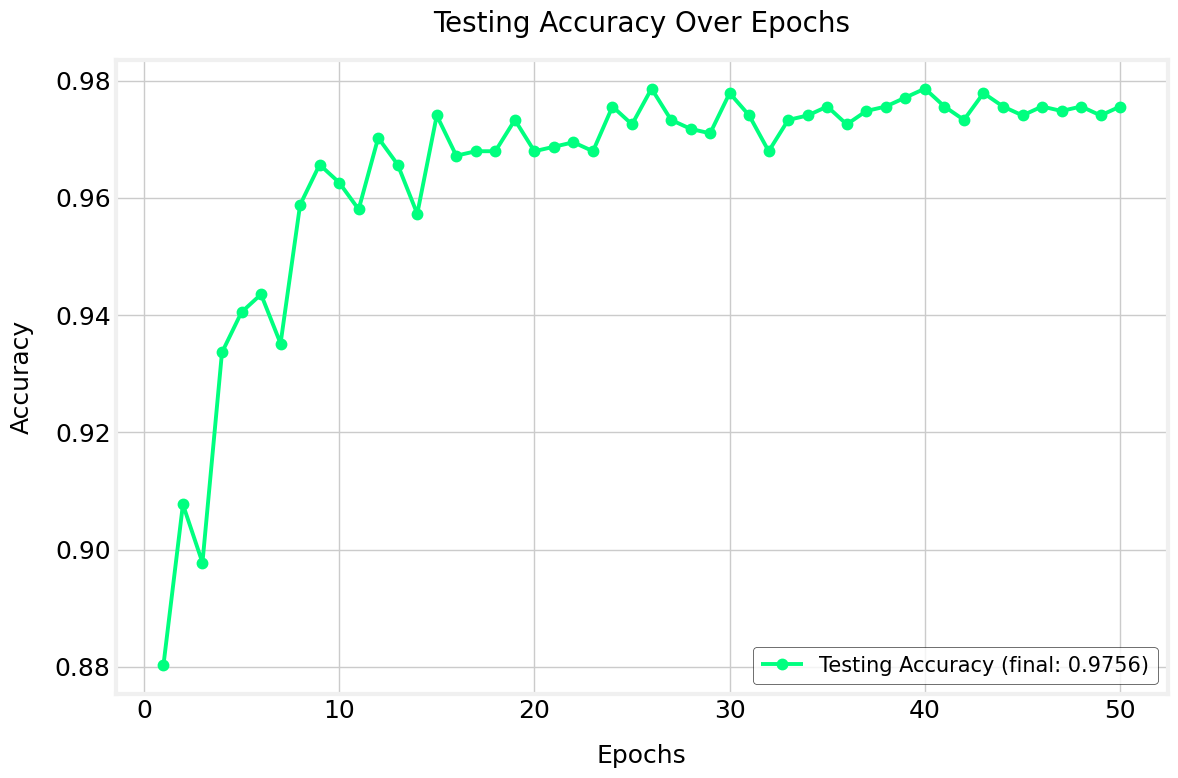

In [211]:
import matplotlib.pyplot as plt

# Assuming you have these in your history object:
train_acc_b = histb.history['accuracy']
test_acc_b = histb.history['val_accuracy']
epochs_range = range(1, len(train_acc_b) + 1)

final_test_acc_b = test_acc_b[-1]

plt.figure(figsize=(12, 8), facecolor='white')
plt.style.use('fivethirtyeight')


# Testing accuracy: orange stars
plt.plot(
    epochs_range, test_acc_b, color='springgreen', marker='.', linestyle='-', 
    linewidth=2.8, markersize=13, markerfacecolor='springgreen', markeredgewidth=2, 
    label=f'Testing Accuracy (final: {final_test_acc_b:.4f})'
)

plt.title('Testing Accuracy Over Epochs', fontsize=20, color='black', pad=20)
plt.xlabel('Epochs', fontsize=18, color='black', labelpad=15)
plt.ylabel('Accuracy', fontsize=18, color='black', labelpad=15)

# Set tick labels to black and larger
plt.xticks(fontsize=18, color='black')
plt.yticks(fontsize=18, color='black')

# Legend: larger and black text
plt.legend(fontsize=15, frameon=True, facecolor='white', edgecolor='black', loc='lower right')

plt.gca().set_facecolor('white')
plt.grid(True)
plt.tight_layout()
plt.show()

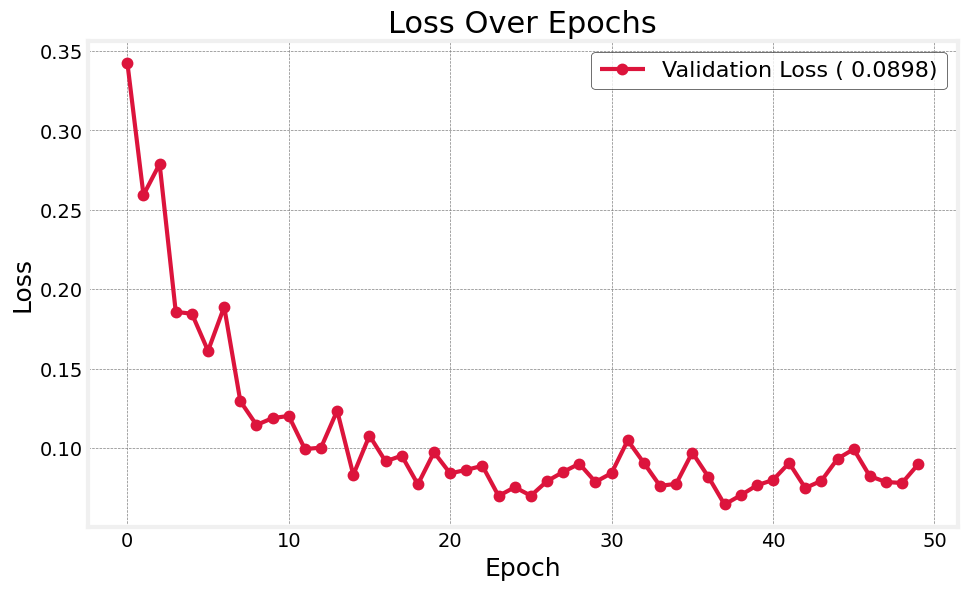

In [212]:
last_val_loss_b = histb.history['val_loss'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(histb.history['val_loss'], 
         label=f'Validation Loss ( {last_val_loss_b:.4f})', 
         color='crimson', marker='.', linestyle='-', markersize=13, markerfacecolor='crimson', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Loss', fontsize=18, color='black')
plt.title('Loss Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

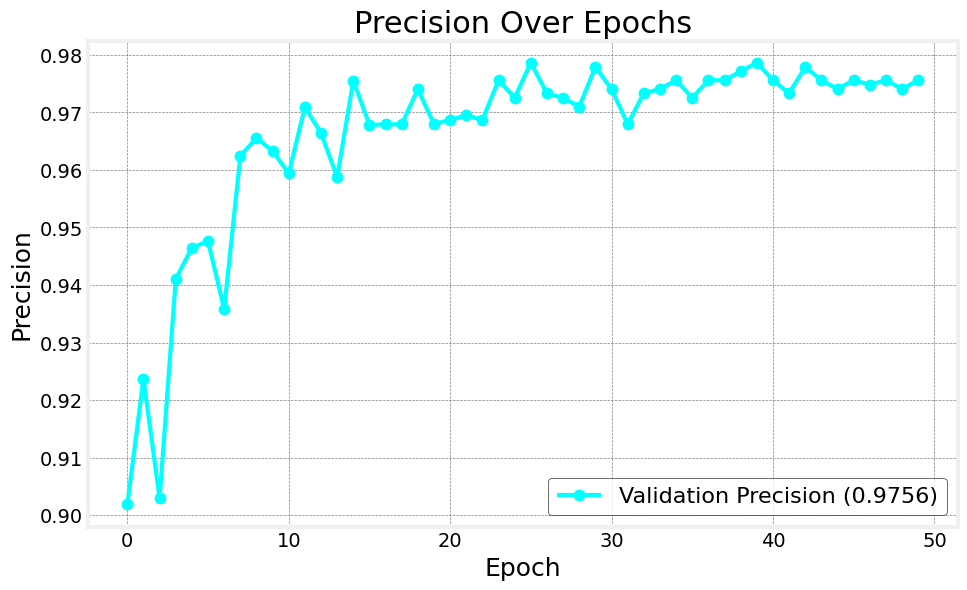

In [213]:
last_val_precision_b = histb.history['val_precision_7'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(histb.history['val_precision_7'], 
         label=f'Validation Precision ({last_val_precision_b:.4f})', 
         color='cyan', marker='.', linestyle='-', markersize=13, markerfacecolor='cyan', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Precision', fontsize=18, color='black')
plt.title('Precision Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

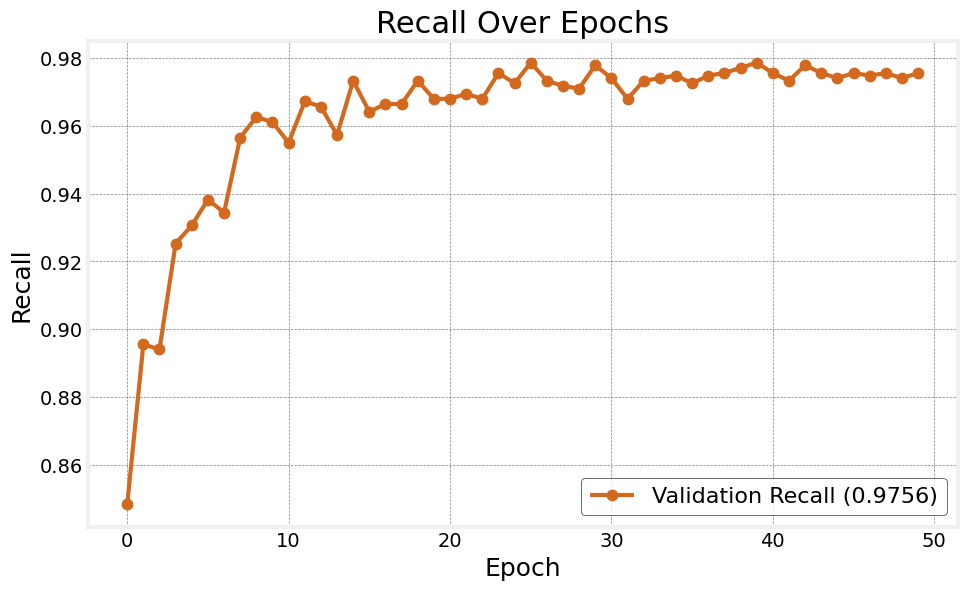

In [214]:
# Get the last value of validation recall
last_val_recall_b = histb.history['val_recall_7'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(histb.history['val_recall_7'], 
         label=f'Validation Recall ({last_val_recall_b:.4f})', 
         color='chocolate', marker='.', linestyle='-', markersize=13, markerfacecolor='chocolate', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Recall', fontsize=18, color='black')
plt.title('Recall Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

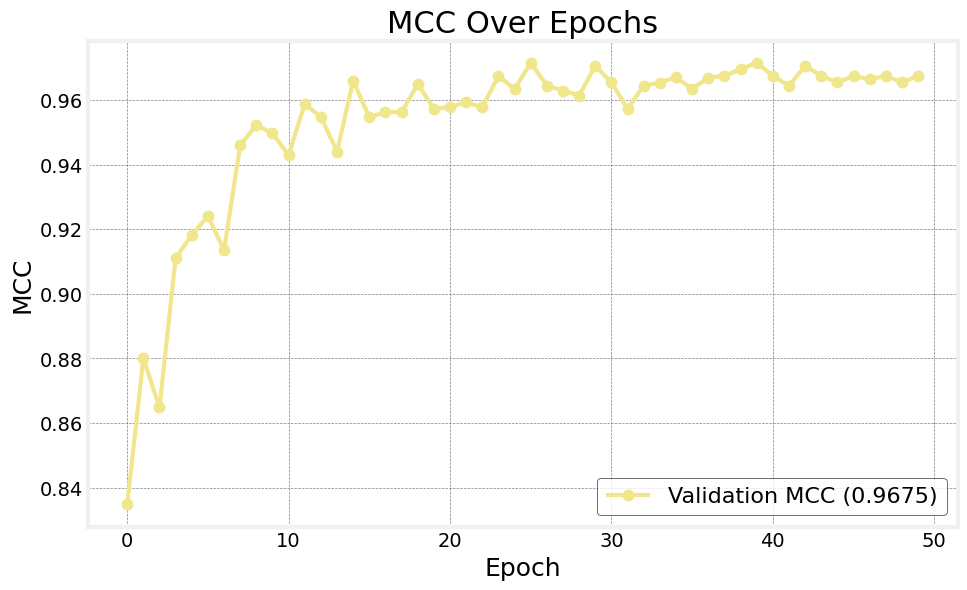

In [215]:
last_val_mcc_b = histb.history['val_matthews_correlation_b'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(histb.history['val_matthews_correlation_b'], 
         label=f'Validation MCC ({last_val_mcc_b:.4f})', 
         color='khaki', marker='.', linestyle='-', markersize=13, markerfacecolor='khaki', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('MCC', fontsize=18, color='black')
plt.title('MCC Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

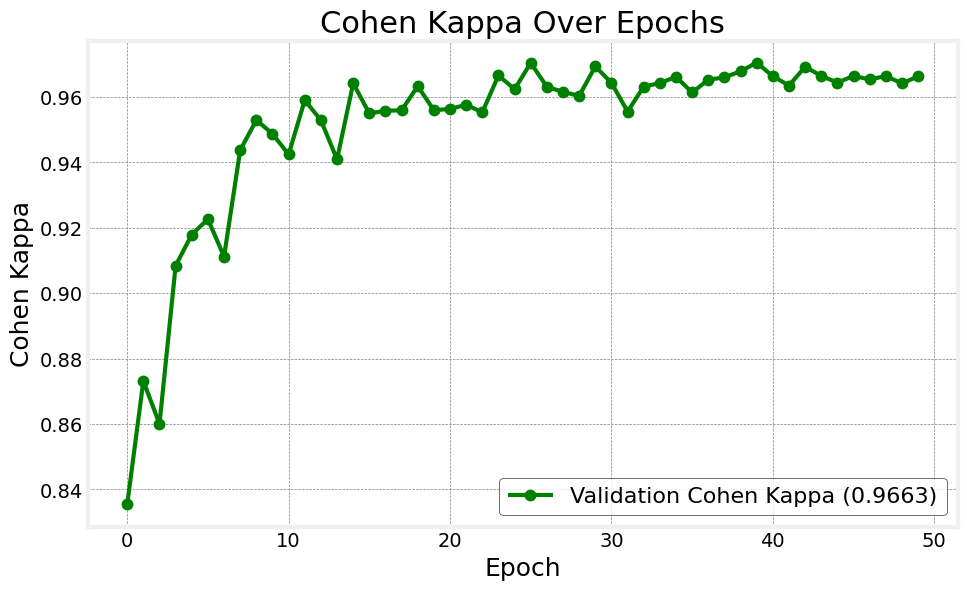

In [218]:
# Get the last value of validation Cohen Kappa
last_val_kappa_b = histb.history['val_cohen_kappa_b'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(histb.history['val_cohen_kappa_b'], 
         label=f'Validation Cohen Kappa ({last_val_kappa_b:.4f})', 
         color='green', marker='.', linestyle='-', markersize=13, markerfacecolor='green', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Cohen Kappa', fontsize=18, color='black')
plt.title('Cohen Kappa Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

41/41 [==============================] - 2s 43ms/step


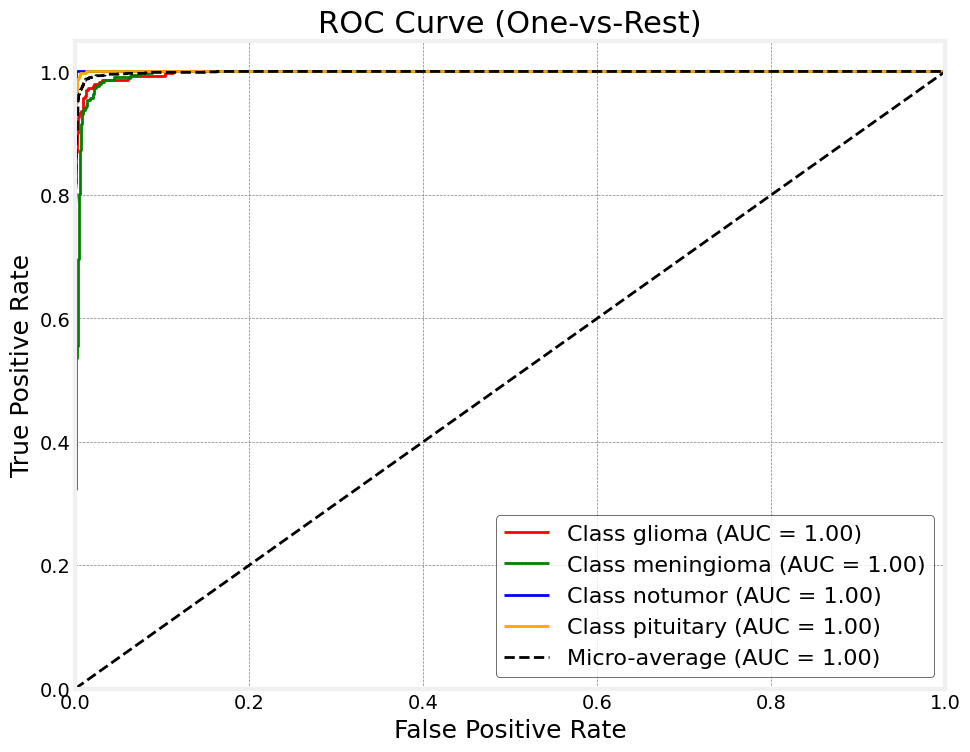

In [207]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get true labels and predicted probabilities
test_steps_b = test_generator.samples // test_generator.batch_size + 1
y_score_b = modelb.predict(test_generator, steps=test_steps)
y_true_b = test_generator.classes
n_classes = y_score_b.shape[1]

# Binarize the true labels for ROC
y_true_bin_b = label_binarize(y_true_b, classes=np.arange(n_classes))
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin_b[:, i], y_score_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin_b.ravel(), y_score_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot
plt.figure(figsize=(10, 8), facecolor='white')
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
class_names = list(test_generator.class_indices.keys())

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--', lw=2,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18, color='black')
plt.ylabel('True Positive Rate', fontsize=18, color='black')
plt.title('ROC Curve (One-vs-Rest)', fontsize=22, color='black')
plt.legend(loc="lower right", facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [229]:
#######################################################################################################################################################

poroposed model

In [268]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall, AUC, RootMeanSquaredError
import tensorflow.keras.backend as K
from tensorflow.keras.applications import Xception  # Changed here
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, jaccard_score, r2_score

# Define custom metrics
def matthews_correlation_a(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon())

def cohen_kappa_a(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)
    confusion = tf.math.confusion_matrix(y_true, y_pred, num_classes=4)
    n = K.sum(confusion)
    sum_po = K.sum(tf.linalg.diag_part(confusion))
    po = sum_po / n
    pe = K.sum(K.sum(confusion, axis=0) * K.sum(confusion, axis=1)) / (n * n)
    return (po - pe) / (1 - pe + K.epsilon())

def jaccard_index_a(y_true, y_pred):
    y_pred = K.round(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1])
    jac = (intersection + K.epsilon()) / (sum_ - intersection + K.epsilon())
    return K.mean(jac)

def r2_score_a(y_true, y_pred):
    ss_res =  K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

def logcosh_a(y_true, y_pred):
    return K.mean(tf.math.log(tf.math.cosh(y_pred - y_true)))

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, 
                                     BatchNormalization, Dropout, GlobalAveragePooling2D, Concatenate, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Add
from tensorflow.keras.models import Model

input_layer = Input(shape=(224,224,3))

# Block 1 with residual connection
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
residual1 = Conv2D(32, (1, 1), activation='linear', padding='same')(input_layer)  # 1x1 conv to match dimensions for residual
x = Add()([x, residual1])  # Skip connection
x = MaxPooling2D((2, 2))(x)

# Block 2 with residual connection
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
residual2 = Conv2D(64, (1, 1), activation='linear', padding='same')(x)  # 1x1 conv for residual
x = Add()([x, residual2])  # Skip connection
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
residual3 = Conv2D(64, (1, 1), activation='linear', padding='same')(x)
x = Add()([x, residual3])  # Skip connection
x = MaxPooling2D((2, 2))(x)

# Block 3 with residual connection
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
residual4 = Conv2D(128, (1, 1), activation='linear', padding='same')(x)
x = Add()([x, residual4])  # Skip connection
x = MaxPooling2D((2, 2))(x)

# Flatten and original dense layers (no changes here)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Compile the model
modelp = Model(inputs=input_layer, outputs=predictions)

modelp = Model(inputs=input_layer, outputs=predictions)
# Compile
modelp.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(),
        'mae',
        'mse',
        RootMeanSquaredError(),
        matthews_correlation_b,
        cohen_kappa_b,
        jaccard_index_b,
        r2_score_b,
        logcosh_b
    ]
)
# Print the model summary
modelp.summary()
print(f"Total params: {modelp.count_params()}")

# Data generators (replace with your own)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_a = ImageDataGenerator(rescale=1./255)
val_datagen_a = ImageDataGenerator(rescale=1./255)

# <<<<<<<<<<< REPLACE THESE PATHS WITH YOUR ACTUAL DATA FOLDERS >>>>>>>>>>
train_dir_a = r'D:/BRAIN DATA/bt mri 7023/training'  # e.g. r'C:/Users/YourName/data/train'
val_dir_a = r'D:/BRAIN DATA/bt mri 7023/testing'      # e.g. r'C:/Users/YourName/data/val'
train_generator_a = train_datagen_a.flow_from_directory(
    train_dir_a,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator_a = val_datagen_a.flow_from_directory(
    val_dir_a,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_150 (Conv2D)            (None, 224, 224, 32  896         ['input_21[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_158 (Batch  (None, 224, 224, 32  128        ['conv2d_150[0][0]']             
 Normalization)                 )                                                          

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU



In [269]:
# Train the model
histp = modelp.fit(
    train_generator_a,
    epochs=50,
    validation_data=val_generator_a
)

Epoch 1/50
179/179 [==============================] - 13s 66ms/step - loss: 1.0907 - accuracy: 0.7803 - precision_16: 0.7951 - recall_16: 0.7635 - auc_16: 0.9266 - mae: 0.1348 - mse: 0.0835 - root_mean_squared_error: 0.2890 - matthews_correlation_b: 0.7065 - cohen_kappa_b: 0.7001 - jaccard_index_b: 0.7631 - r2_score_b: 0.5532 - logcosh_b: 0.0380 - val_loss: 2.3214 - val_accuracy: 0.3051 - val_precision_16: 0.3053 - val_recall_16: 0.3051 - val_auc_16: 0.6444 - val_mae: 0.3290 - val_mse: 0.2716 - val_root_mean_squared_error: 0.5212 - val_matthews_correlation_b: 0.0737 - val_cohen_kappa_b: -0.0052 - val_jaccard_index_b: 0.3051 - val_r2_score_b: -0.4488 - val_logcosh_b: 0.1208
Epoch 2/50
179/179 [==============================] - 12s 65ms/step - loss: 0.3148 - accuracy: 0.8944 - precision_16: 0.9008 - recall_16: 0.8841 - auc_16: 0.9821 - mae: 0.0788 - mse: 0.0403 - root_mean_squared_error: 0.2009 - matthews_correlation_b: 0.8569 - cohen_kappa_b: 0.8554 - jaccard_index_b: 0.8841 - r2_score_

In [270]:
train_score_p = modelp.evaluate(train_generator_a, verbose=1)
valid_score_p = modelp.evaluate(test_generator, verbose=1)


print(f"Train Loss: {train_score_p[0]:.4f}")
print(f"Train Accuracy: {train_score_p[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score_p[0]:.4f}")
print(f"Validation Accuracy: {valid_score_p[1]*100:.2f}%")
print('-' * 20)

41/41 [==============================] - 5s 115ms/step - loss: 0.1586 - accuracy: 0.9802 - precision_16: 0.9802 - recall_16: 0.9802 - auc_16: 0.9917 - mae: 0.0106 - mse: 0.0091 - root_mean_squared_error: 0.0956 - matthews_correlation_b: 0.9736 - cohen_kappa_b: 0.0686 - jaccard_index_b: 0.9802 - r2_score_b: 0.9512 - logcosh_b: 0.0040
Train Loss: 0.0000
Train Accuracy: 100.00%
--------------------
Validation Loss: 0.1586
Validation Accuracy: 98.02%
--------------------


41/41 [==============================] - 2s 43ms/step


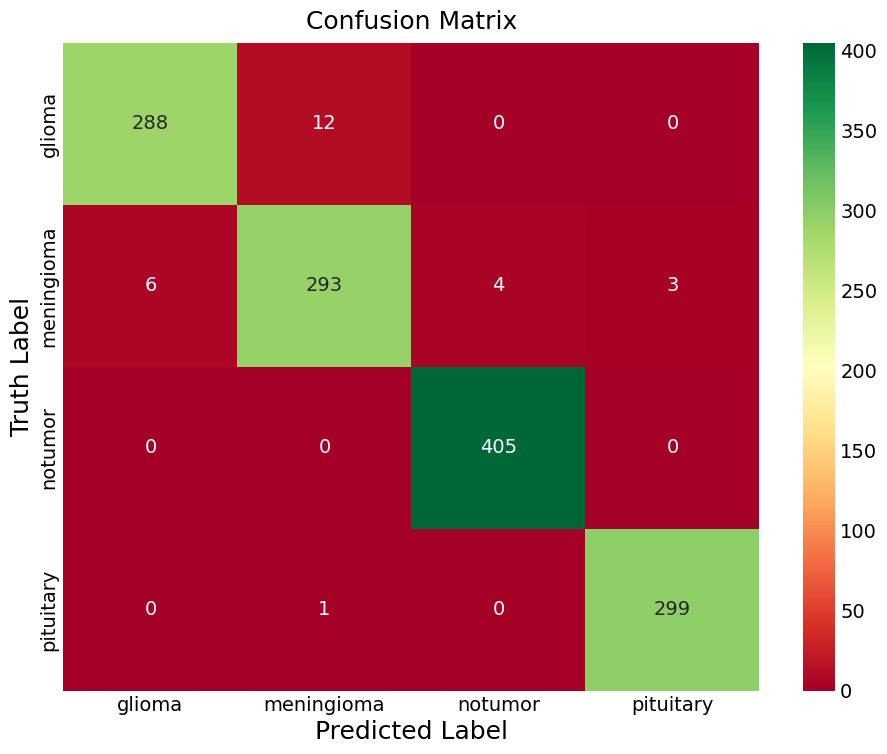

In [274]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Model predictions
preds_p = modelp.predict(test_generator)
y_pred_p = np.argmax(preds_p, axis=1)
class_dir_p = train_generator_a.class_indices
classes = list(class_dir.keys())

# Confusion matrix
cm_p = confusion_matrix(test_generator.classes, y_pred_p)
labels = list(class_dir.keys())

# Plot with white background and color bar
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
sns.heatmap(
    cm_p, annot=True, fmt='d', cmap='RdYlGn',
    xticklabels=labels, yticklabels=labels,
    ax=ax, cbar=True  # Show color bar
)
ax.set_xlabel('Predicted Label',fontsize=18, color='black')
ax.set_ylabel('Truth Label',fontsize=18, color='black')
ax.set_title('Confusion Matrix',fontsize=18, color='black', pad=10)
ax.set_facecolor('white')  # Ensure axes background is white
plt.show()

41/41 [==============================] - 2s 43ms/step


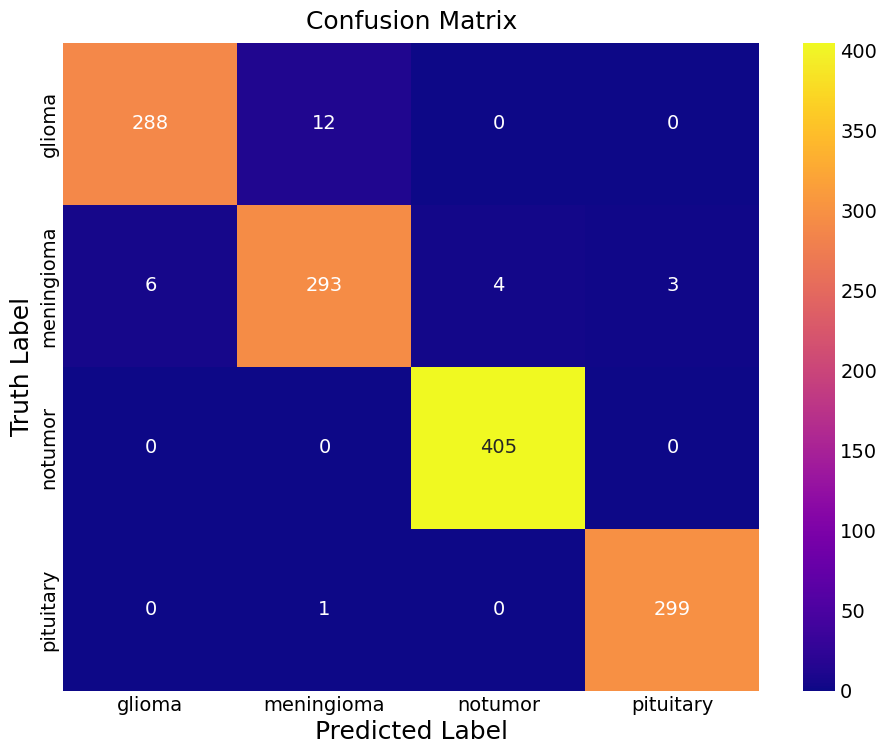

In [275]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Model predictions
preds_p = modelp.predict(test_generator)
y_pred_p = np.argmax(preds_p, axis=1)
class_dir_p = train_generator_a.class_indices
classes = list(class_dir.keys())

# Confusion matrix
cm_p = confusion_matrix(test_generator.classes, y_pred_p)
labels = list(class_dir.keys())

# Plot with white background and color bar
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
sns.heatmap(
    cm_p, annot=True, fmt='d', cmap='plasma',
    xticklabels=labels, yticklabels=labels,
    ax=ax, cbar=True  # Show color bar
)
ax.set_xlabel('Predicted Label',fontsize=18, color='black')
ax.set_ylabel('Truth Label',fontsize=18, color='black')
ax.set_title('Confusion Matrix',fontsize=18, color='black', pad=10)
ax.set_facecolor('white')  # Ensure axes background is white
plt.show()

41/41 [==============================] - 2s 45ms/step


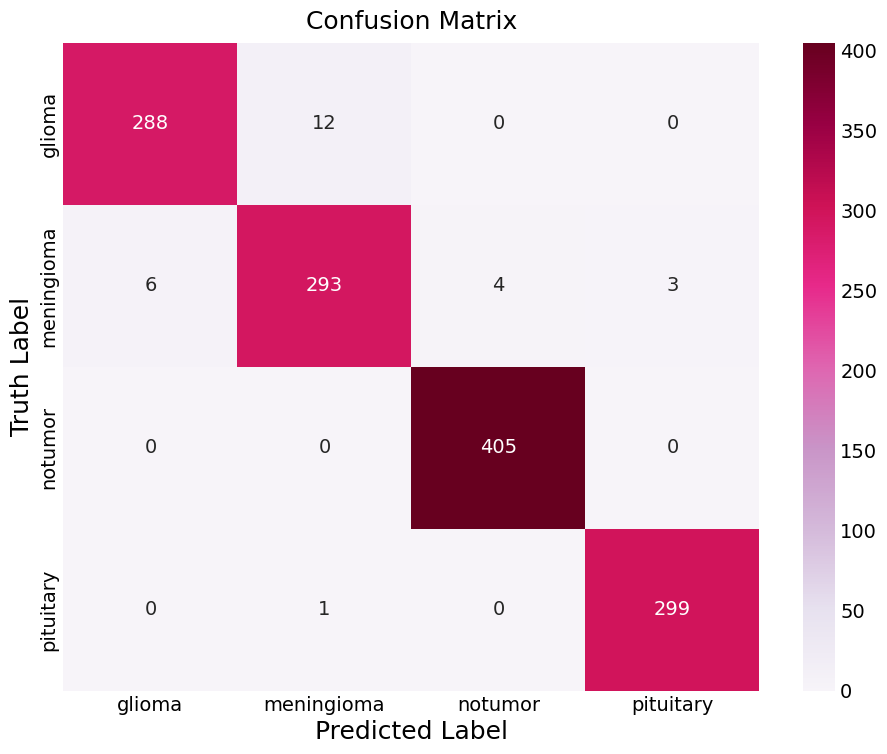

In [306]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Model predictions
preds_p = modelp.predict(test_generator)
y_pred_p = np.argmax(preds_p, axis=1)
class_dir_p = train_generator_a.class_indices
classes = list(class_dir.keys())

# Confusion matrix
cm_p = confusion_matrix(test_generator.classes, y_pred_p)
labels = list(class_dir.keys())

# Plot with white background and color bar
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
sns.heatmap(
    cm_p, annot=True, fmt='d', cmap='PuRd',
    xticklabels=labels, yticklabels=labels,
    ax=ax, cbar=True  # Show color bar
)
ax.set_xlabel('Predicted Label',fontsize=18, color='black')
ax.set_ylabel('Truth Label',fontsize=18, color='black')
ax.set_title('Confusion Matrix',fontsize=18, color='black', pad=10)
ax.set_facecolor('white')  # Ensure axes background is white
plt.show()

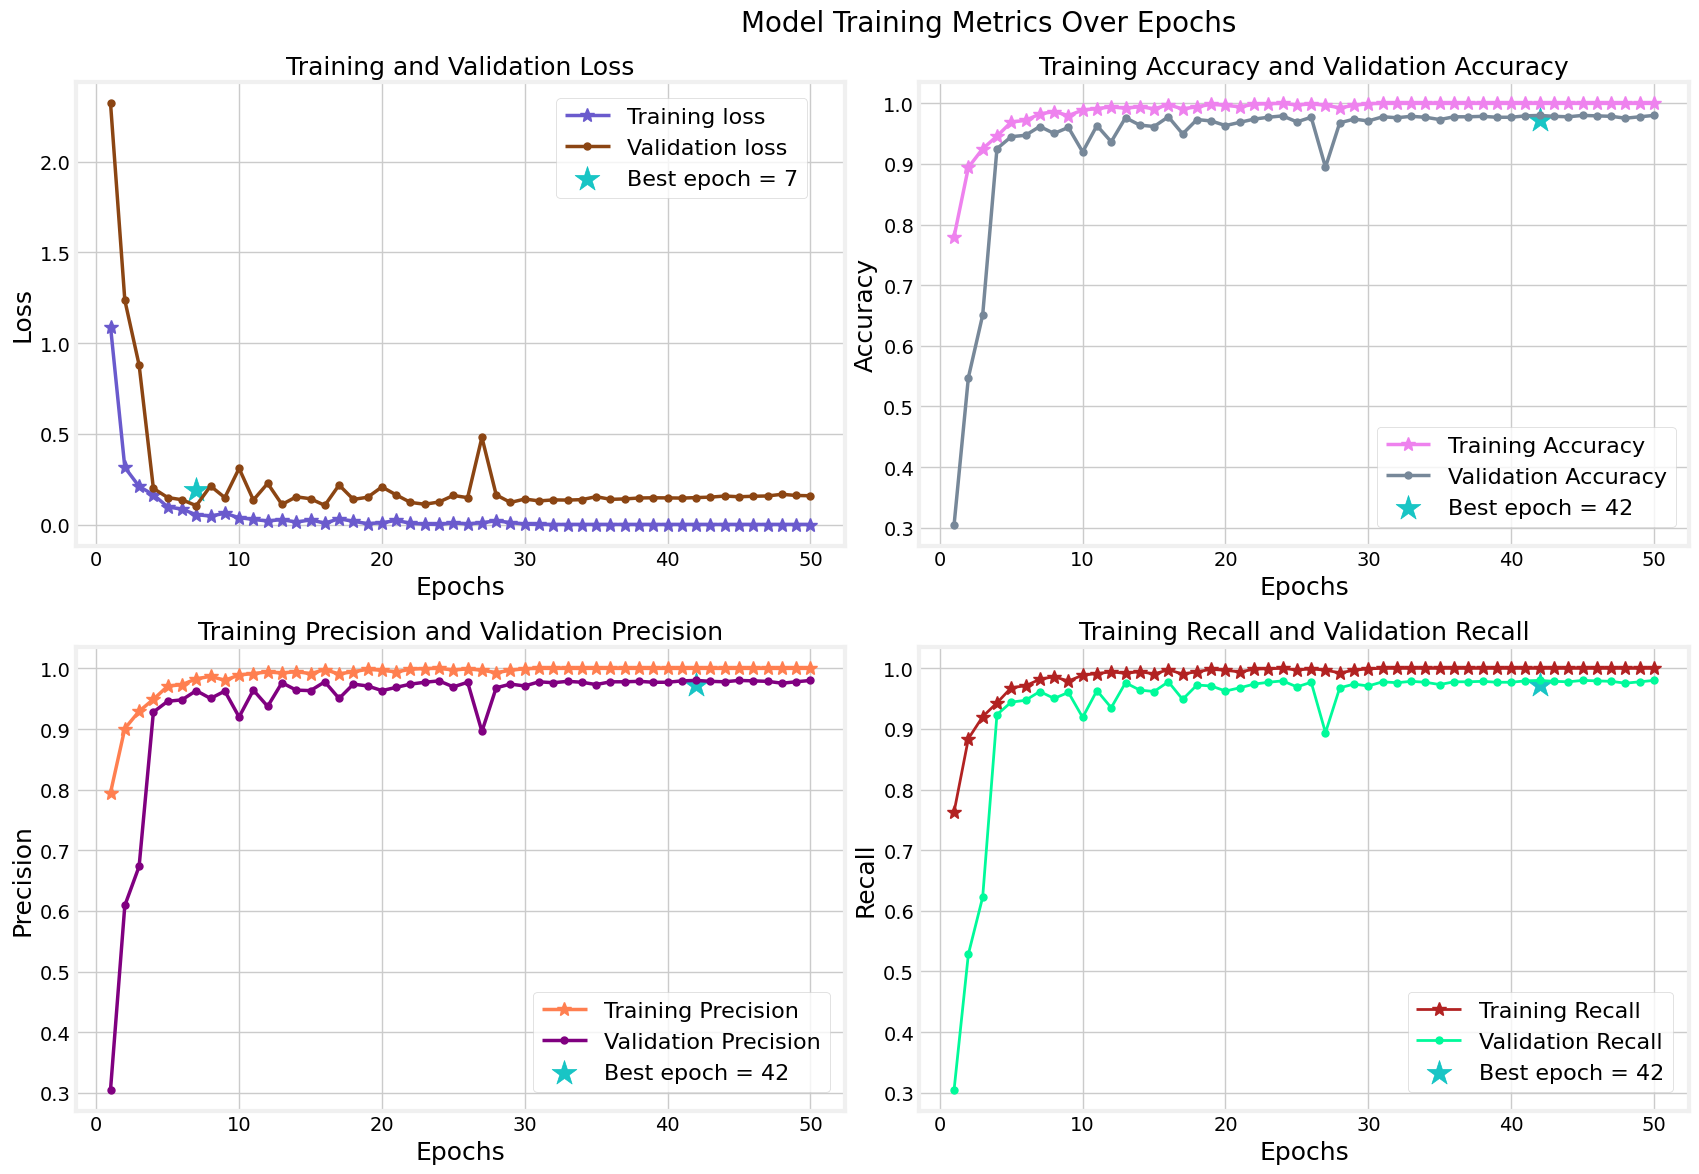

In [316]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'history' object is already available and contains the model training history
tr_acc_p = histp.history['accuracy']
tr_loss_p = histp.history['loss']
tr_per_p = histp.history['precision_16']
tr_recall_p = histp.history['recall_16']
val_acc_p = histp.history['val_accuracy']
val_loss_p = histp.history['val_loss']
val_per_p = histp.history['val_precision_16']
val_recall_p = histp.history['val_recall_16']

# Best epoch calculations
index_loss_p = np.argmin(val_loss_p)
val_lowest_p = val_loss_b[index_loss_p]
index_acc_p = np.argmax(val_acc_p)
acc_highest_p = val_acc_b[index_acc_p]
index_precision_p = np.argmax(val_per_p)
per_highest_p = val_per_b[index_precision_p]
index_recall_p = np.argmax(val_recall_p)
recall_highest_p = val_recall_b[index_recall_p]

Epochs = [i + 1 for i in range(len(tr_acc_p))]
loss_label_p = f'Best epoch = {str(index_loss_p + 1)}'
acc_label_p = f'Best epoch = {str(index_acc_p + 1)}'
per_label_p = f'Best epoch = {str(index_precision_p + 1)}'
recall_label_p = f'Best epoch = {str(index_recall_p + 1)}'

# Create a figure with a white background
plt.figure(figsize=(20, 12), facecolor='white')

# First subplot (Training and Validation Loss)
plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss_p, 'slateblue', label='Training loss', marker='*', linestyle='-', markersize=10, linewidth=2.5)
plt.plot(Epochs, val_loss_p, 'saddlebrown', label='Validation loss', marker='.', linestyle='-', markersize=10, linewidth=2.5)
plt.scatter(index_loss_p + 1, val_lowest_p, s=350, c='c', marker='*', alpha=0.9, label=loss_label_p)
plt.title('Training and Validation Loss', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Loss', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.61, 0.99))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Second subplot (Training and Validation Accuracy)
plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc_p, 'violet', label='Training Accuracy', marker='*', linestyle='-', markersize=10, linewidth=2.5)
plt.plot(Epochs, val_acc_p, 'lightslategrey', label='Validation Accuracy', marker='.', linestyle='-', markersize=10, linewidth=2.5)
plt.scatter(index_acc_p + 1, acc_highest_p, s=350, c='c', marker='*', alpha=0.9, label=acc_label_p)
plt.title('Training Accuracy and Validation Accuracy', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Accuracy', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.58, 0.28))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Third subplot (Training and Validation Precision)
plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per_p, 'coral', label='Training Precision', marker='*', linestyle='-', markersize=10, linewidth=2.5)
plt.plot(Epochs, val_per_p, 'purple', label='Validation Precision', marker='.', linestyle='-', markersize=10, linewidth=2.5)
plt.scatter(index_precision_p + 1, per_highest_p, s=350, c='c', marker='*', alpha=0.9, label=per_label_p)
plt.title('Training Precision and Validation Precision', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Precision', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.58, 0.28))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Fourth subplot (Training and Validation Recall)
plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall_p, 'firebrick', label='Training Recall', marker='*', linestyle='-', markersize=10, linewidth=2)
plt.plot(Epochs, val_recall_p, 'mediumspringgreen', label='Validation Recall', marker='.', linestyle='-', markersize=10, linewidth=2)
plt.scatter(index_recall_p + 1, recall_highest_p, s=350, c='c', marker='*', alpha=0.9, label=recall_label_p)
plt.title('Training Recall and Validation Recall', fontsize=18, color='black')
plt.xlabel('Epochs', fontsize=18, color='black')
plt.ylabel('Recall', fontsize=18, color='black')
plt.legend(loc='upper left', fontsize=16, frameon=True, facecolor='white', bbox_to_anchor=(0.62, 0.28))  # Legend inside graph
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background to white

# Set the overall title and display the figure
plt.suptitle('Model Training Metrics Over Epochs', fontsize=20, color='black')
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Adjust the space for the legend
plt.show()

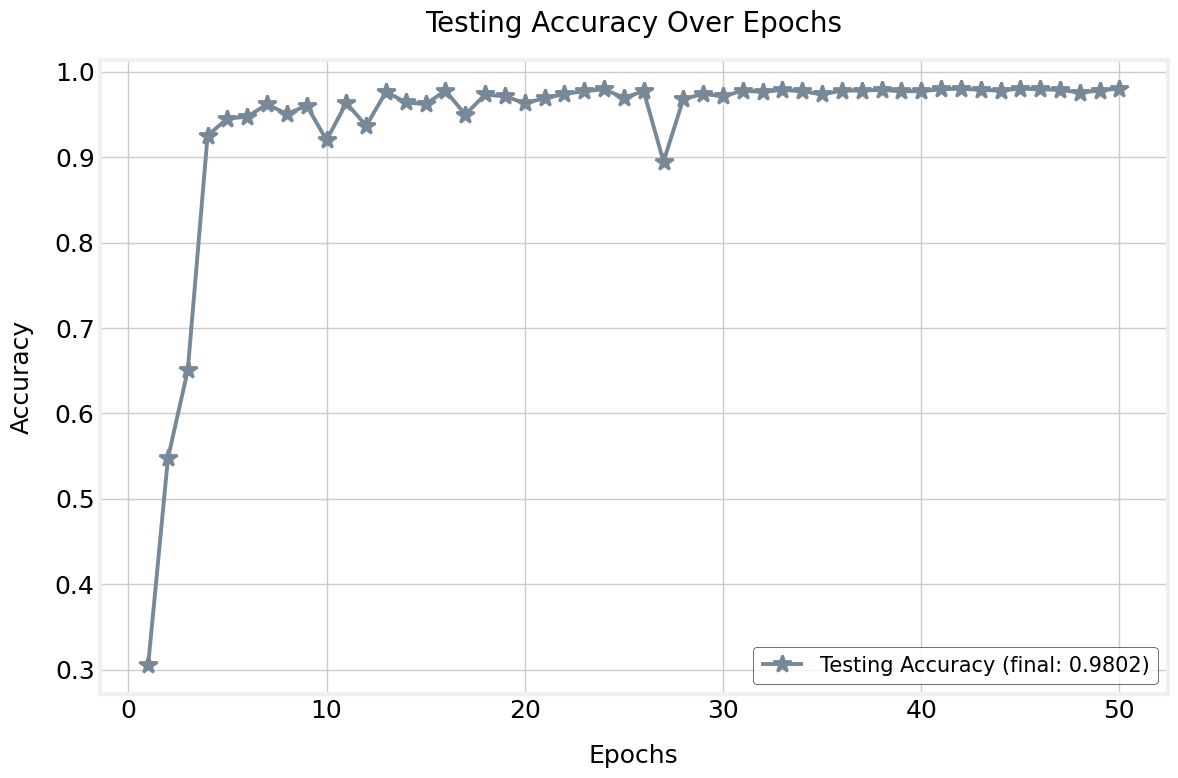

In [369]:
import matplotlib.pyplot as plt

# Assuming you have these in your history object:
train_acc_p = histp.history['accuracy']
test_acc_p = histp.history['val_accuracy']
epochs_range = range(1, len(train_acc_p) + 1)

final_test_acc_p = test_acc_p[-1]

plt.figure(figsize=(12, 8), facecolor='white')
plt.style.use('fivethirtyeight')


# Testing accuracy: orange stars
plt.plot(
    epochs_range, test_acc_p, color='lightslategrey', marker='*', linestyle='-', 
    linewidth=2.8, markersize=13, markerfacecolor='lightslategrey', markeredgewidth=2, 
    label=f'Testing Accuracy (final: {final_test_acc_p:.4f})'
)

plt.title('Testing Accuracy Over Epochs', fontsize=20, color='black', pad=20)
plt.xlabel('Epochs', fontsize=18, color='black', labelpad=15)
plt.ylabel('Accuracy', fontsize=18, color='black', labelpad=15)

# Set tick labels to black and larger
plt.xticks(fontsize=18, color='black')
plt.yticks(fontsize=18, color='black')

# Legend: larger and black text
plt.legend(fontsize=15, frameon=True, facecolor='white', edgecolor='black', loc='lower right')

plt.gca().set_facecolor('white')
plt.grid(True)
plt.tight_layout()
plt.show()

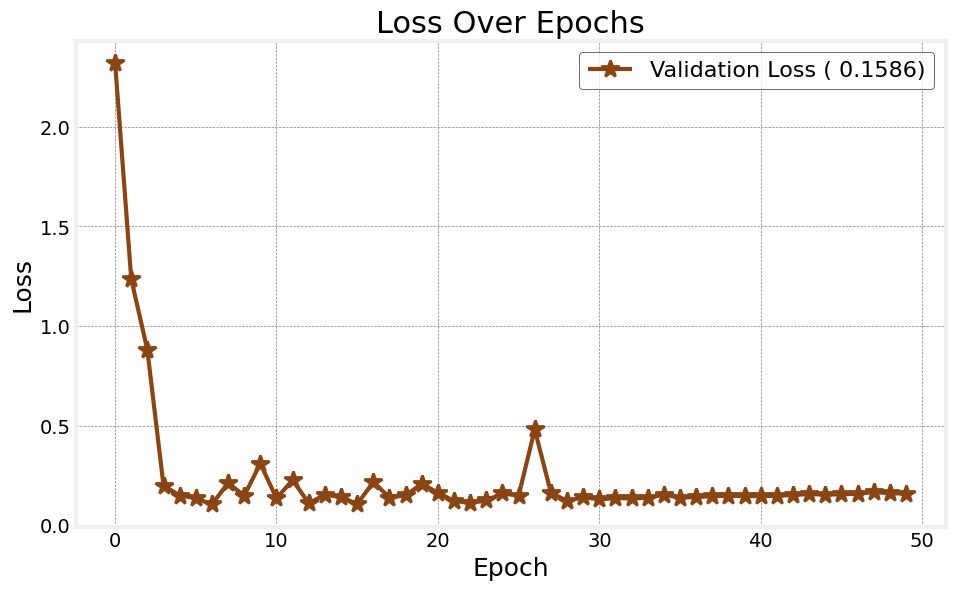

In [368]:
last_val_loss_p = histp.history['val_loss'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(histp.history['val_loss'], 
         label=f'Validation Loss ( {last_val_loss_p:.4f})', 
         color='saddlebrown', marker='*', linestyle='-', markersize=13, markerfacecolor='saddlebrown', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Loss', fontsize=18, color='black')
plt.title('Loss Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

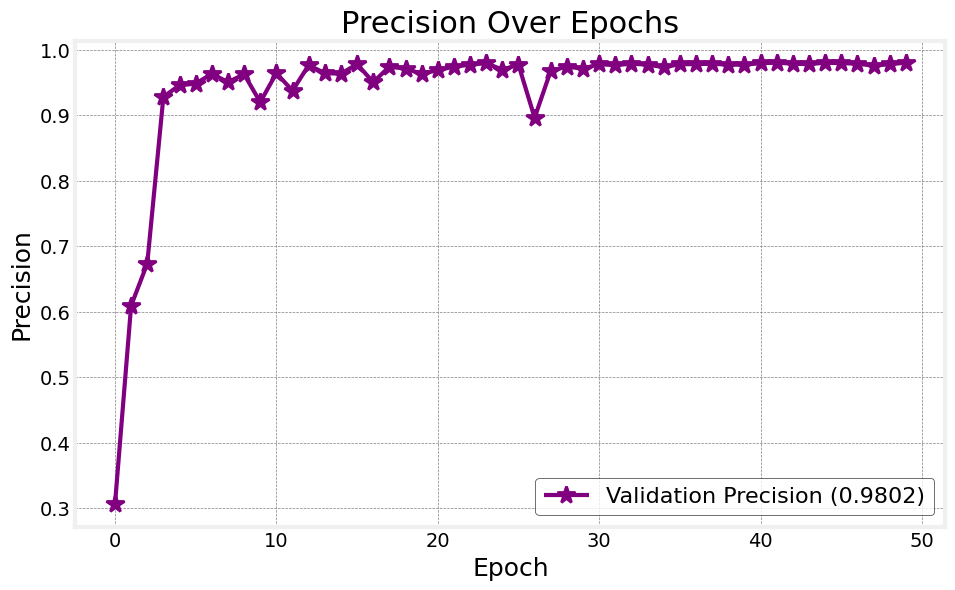

In [367]:
last_val_precision_p = histp.history['val_precision_16'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(histp.history['val_precision_16'], 
         label=f'Validation Precision ({last_val_precision_p:.4f})', 
         color='purple', marker='*', linestyle='-', markersize=13, markerfacecolor='purple', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Precision', fontsize=18, color='black')
plt.title('Precision Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

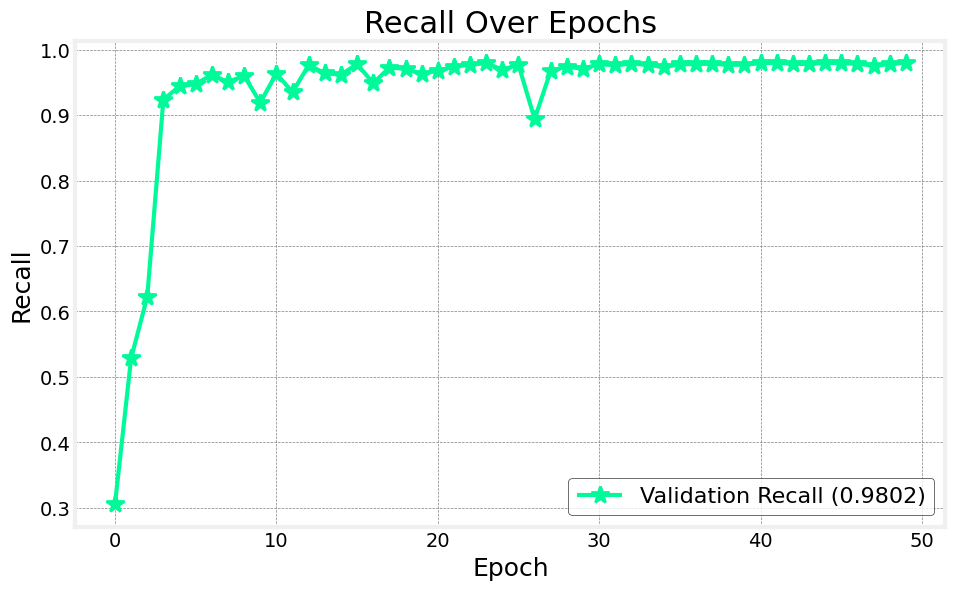

In [366]:
# Get the last value of validation recall
last_val_recall_p = histp.history['val_recall_16'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(histp.history['val_recall_16'], 
         label=f'Validation Recall ({last_val_recall_p:.4f})', 
         color='mediumspringgreen', marker='*', linestyle='-', markersize=13, markerfacecolor='mediumspringgreen', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Recall', fontsize=18, color='black')
plt.title('Recall Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

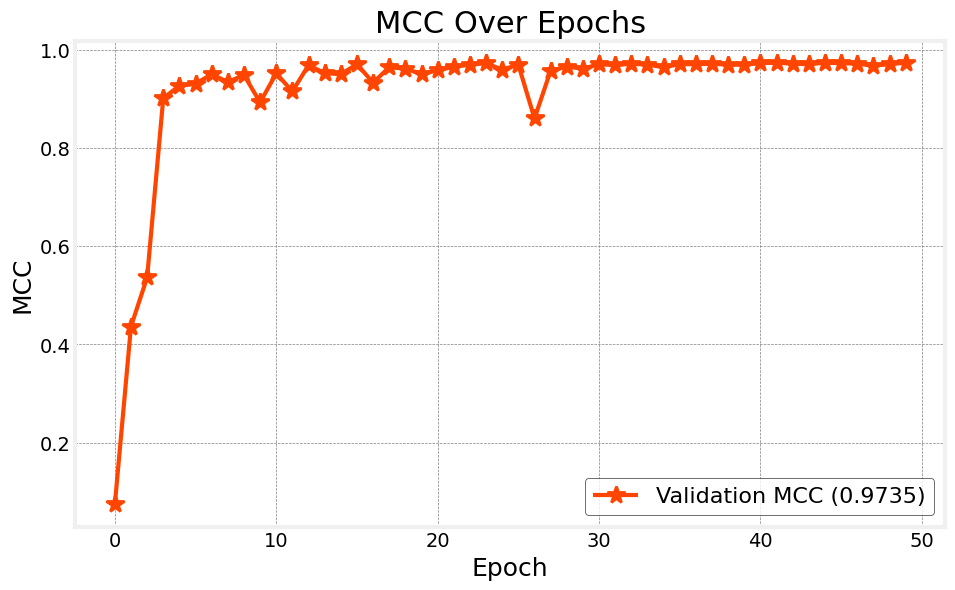

In [365]:
last_val_mcc_p = histp.history['val_matthews_correlation_b'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(histp.history['val_matthews_correlation_b'], 
         label=f'Validation MCC ({last_val_mcc_p:.4f})', 
         color='orangered', marker='*', linestyle='-', markersize=13, markerfacecolor='orangered', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('MCC', fontsize=18, color='black')
plt.title('MCC Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

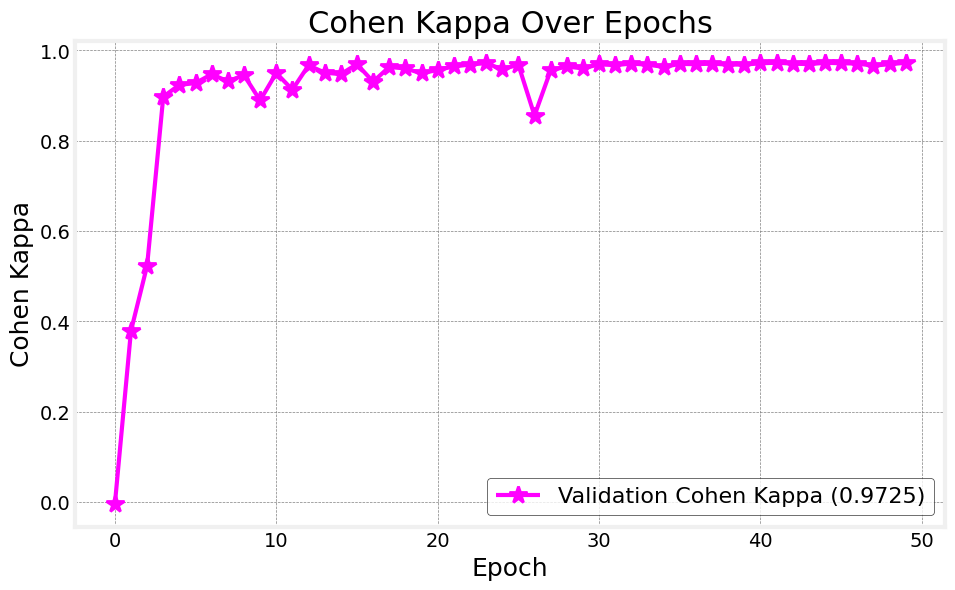

In [364]:
# Get the last value of validation Cohen Kappa
last_val_kappa_p = histp.history['val_cohen_kappa_b'][-1]

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(histp.history['val_cohen_kappa_b'], 
         label=f'Validation Cohen Kappa ({last_val_kappa_p:.4f})', 
         color='magenta', marker='*', linestyle='-', markersize=13, markerfacecolor='magenta', markeredgewidth=2, linewidth=3)
plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Cohen Kappa', fontsize=18, color='black')
plt.title('Cohen Kappa Over Epochs', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

41/41 [==============================] - 2s 47ms/step


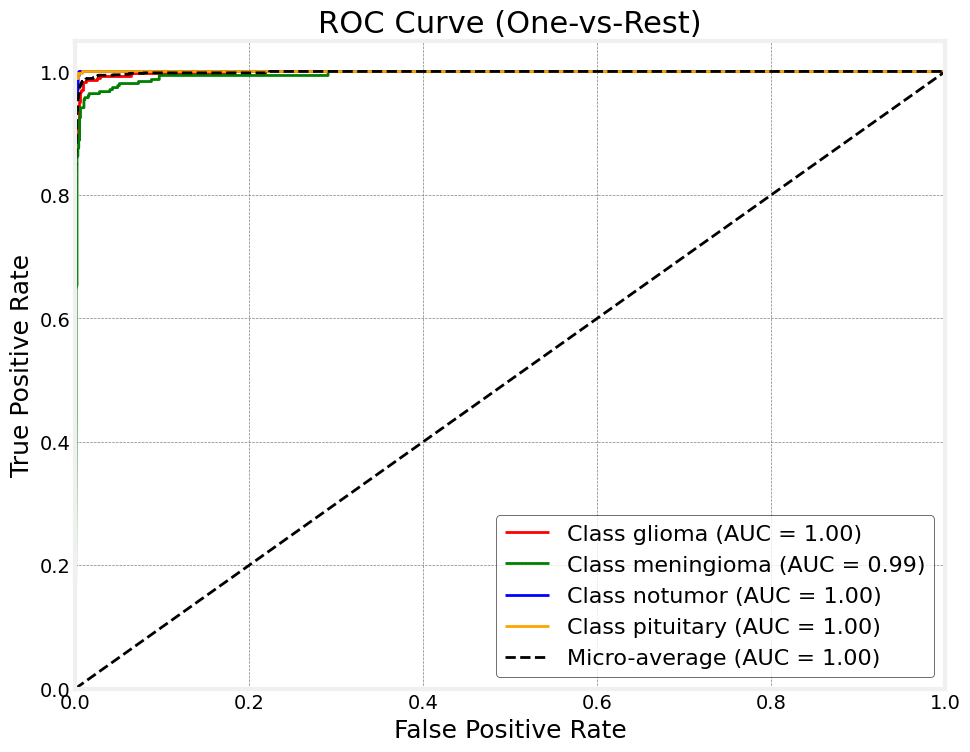

In [318]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get true labels and predicted probabilities
test_steps_p = test_generator.samples // test_generator.batch_size + 1
y_score_p = modelp.predict(test_generator, steps=test_steps)
y_true_p = test_generator.classes
n_classes = y_score_p.shape[1]

# Binarize the true labels for ROC
y_true_bin_p = label_binarize(y_true_p, classes=np.arange(n_classes))
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin_p[:, i], y_score_p[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin_p.ravel(), y_score_p.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot
plt.figure(figsize=(10, 8), facecolor='white')
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
class_names = list(test_generator.class_indices.keys())

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--', lw=2,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18, color='black')
plt.ylabel('True Positive Rate', fontsize=18, color='black')
plt.title('ROC Curve (One-vs-Rest)', fontsize=22, color='black')
plt.legend(loc="lower right", facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
######################################################################################################################################################

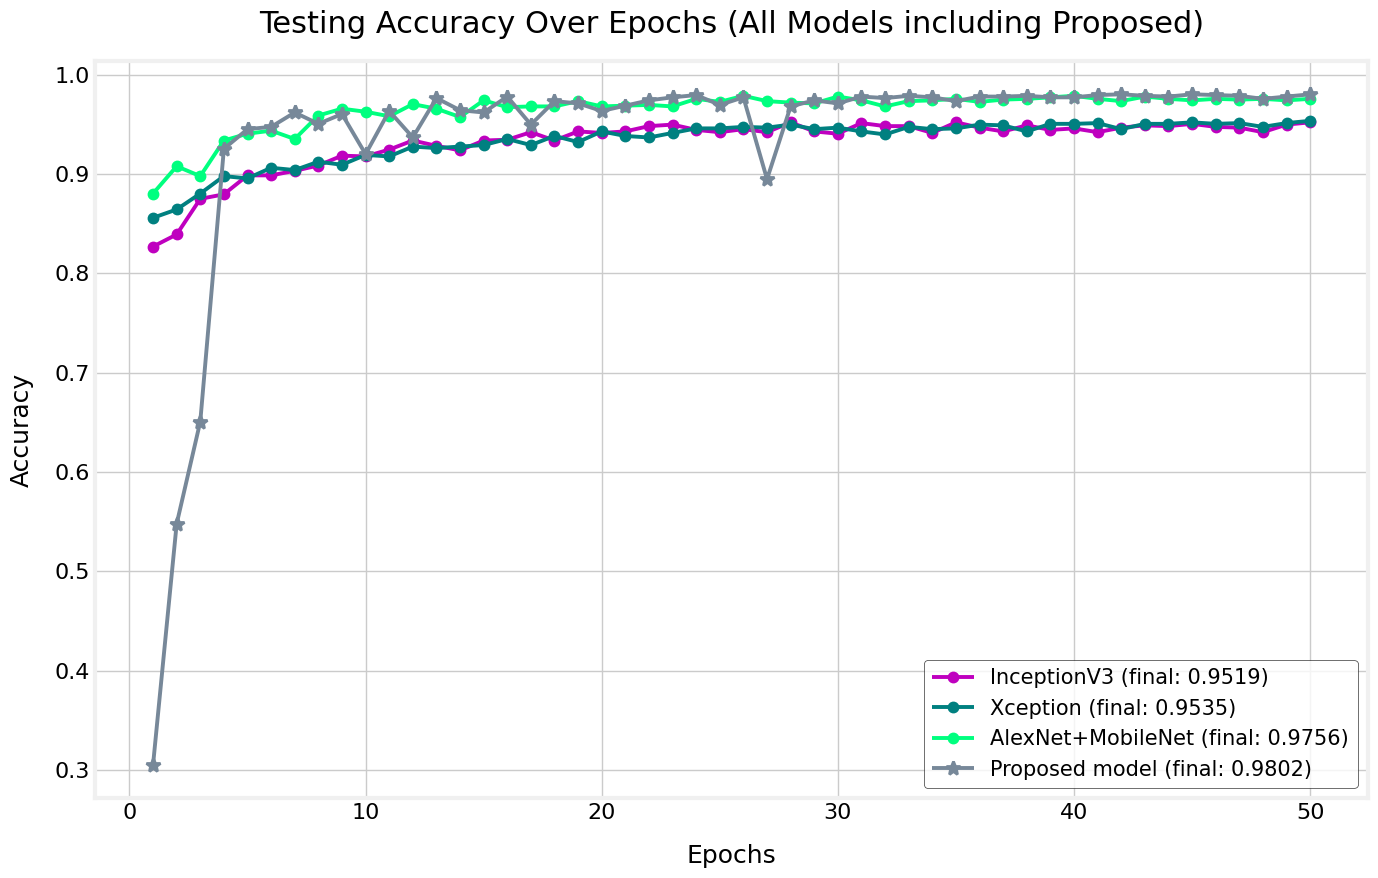

In [363]:
import matplotlib.pyplot as plt

# Model 1 (InceptionV3)
test_acc = hist.history['val_accuracy']
epochs_range_1 = range(1, len(test_acc) + 1)
final_test_acc = test_acc[-1]

# Model 2 (Xception)
test_acc_a = hista.history['val_accuracy']
epochs_range_2 = range(1, len(test_acc_a) + 1)
final_test_acc_a = test_acc_a[-1]

# Model 3 (AlexNet+MobileNet)
test_acc_b = histb.history['val_accuracy']
epochs_range_3 = range(1, len(test_acc_b) + 1)
final_test_acc_b = test_acc_b[-1]

# Proposed Model
test_acc_p = histp.history['val_accuracy']
epochs_range_p = range(1, len(test_acc_p) + 1)
final_test_acc_p = test_acc_p[-1]

plt.figure(figsize=(14, 9), facecolor='white')
plt.style.use('fivethirtyeight')

# Plot all four
plt.plot(
    epochs_range_1, test_acc, color='m', marker='.', linestyle='-', 
    linewidth=2.8, markersize=13, markerfacecolor='m', markeredgewidth=2, 
    label=f'InceptionV3 (final: {final_test_acc:.4f})'
)
plt.plot(
    epochs_range_2, test_acc_a, color='teal', marker='.', linestyle='-', 
    linewidth=2.8, markersize=13, markerfacecolor='teal', markeredgewidth=2, 
    label=f'Xception (final: {final_test_acc_a:.4f})'
)
plt.plot(
    epochs_range_3, test_acc_b, color='springgreen', marker='.', linestyle='-', 
    linewidth=2.8, markersize=13, markerfacecolor='springgreen', markeredgewidth=2, 
    label=f'AlexNet+MobileNet (final: {final_test_acc_b:.4f})'
)
plt.plot(
    epochs_range_p, test_acc_p, color='lightslategrey', marker='*', linestyle='-', 
    linewidth=2.8, markersize=10, markerfacecolor='lightslategrey', markeredgewidth=2, 
    label=f'Proposed model (final: {final_test_acc_p:.4f})'
)

plt.title('Testing Accuracy Over Epochs (All Models including Proposed)', fontsize=22, color='black', pad=20)
plt.xlabel('Epochs', fontsize=18, color='black', labelpad=15)
plt.ylabel('Accuracy', fontsize=18, color='black', labelpad=15)
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')
plt.legend(fontsize=15, frameon=True, facecolor='white', edgecolor='black', loc='lower right')
plt.gca().set_facecolor('white')
plt.grid(True)
plt.tight_layout()
plt.show()

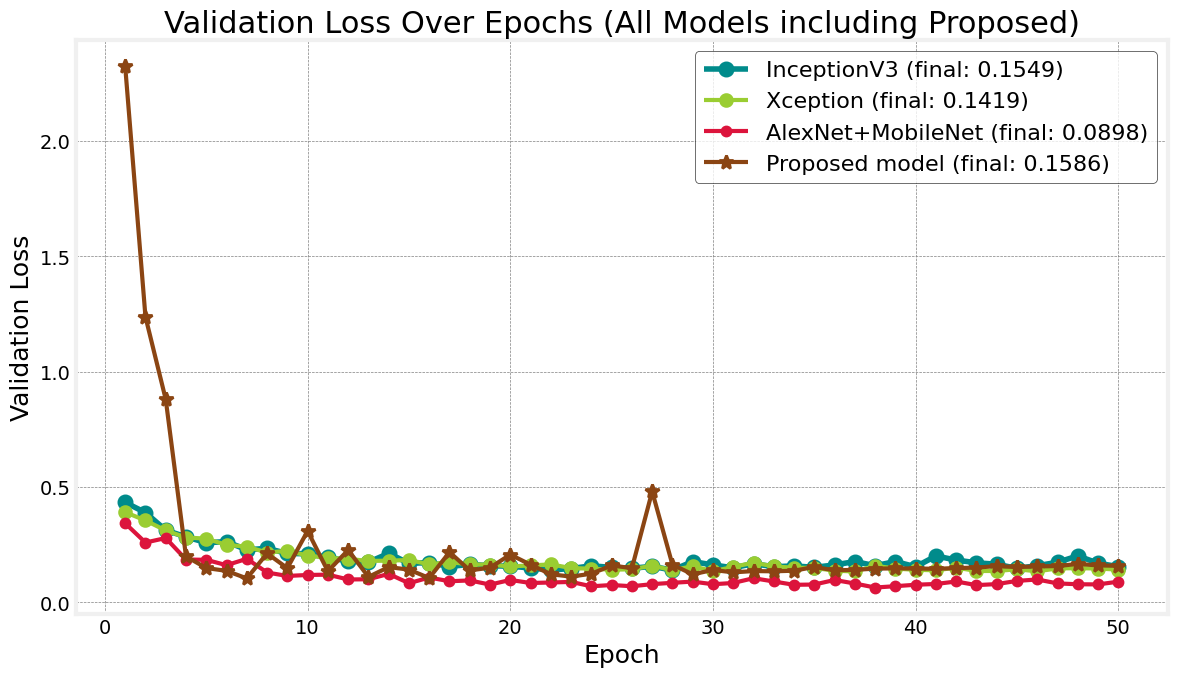

In [362]:
import matplotlib.pyplot as plt

# Model 1 (InceptionV3)
val_loss_1 = hist.history['val_loss']
epochs_1 = range(1, len(val_loss_1) + 1)
last_val_loss_1 = val_loss_1[-1]

# Model 2 (Xception)
val_loss_2 = hista.history['val_loss']
epochs_2 = range(1, len(val_loss_2) + 1)
last_val_loss_2 = val_loss_2[-1]

# Model 3 (AlexNet+MobileNet)
val_loss_3 = histb.history['val_loss']
epochs_3 = range(1, len(val_loss_3) + 1)
last_val_loss_3 = val_loss_3[-1]

# Proposed Model
val_loss_p = histp.history['val_loss']
epochs_p = range(1, len(val_loss_p) + 1)
last_val_loss_p = val_loss_p[-1]

plt.figure(figsize=(12, 7), facecolor='white')

plt.plot(
    epochs_1, val_loss_1, color='darkcyan', marker='.', linestyle='-', 
    markersize=17, markerfacecolor='darkcyan', markeredgewidth=3, linewidth=4,
    label=f'InceptionV3 (final: {last_val_loss_1:.4f})'
)
plt.plot(
    epochs_2, val_loss_2, color='yellowgreen', marker='.', linestyle='-', 
    markersize=15, markerfacecolor='yellowgreen', markeredgewidth=3, linewidth=3,
    label=f'Xception (final: {last_val_loss_2:.4f})'
)
plt.plot(
    epochs_3, val_loss_3, color='crimson', marker='.', linestyle='-', 
    markersize=13, markerfacecolor='crimson', markeredgewidth=2, linewidth=3,
    label=f'AlexNet+MobileNet (final: {last_val_loss_3:.4f})'
)
plt.plot(
    epochs_p, val_loss_p, color='saddlebrown', marker='*', linestyle='-', 
    markersize=10, markerfacecolor='saddlebrown', markeredgewidth=2, linewidth=3,
    label=f'Proposed model (final: {last_val_loss_p:.4f})'
)

plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Validation Loss', fontsize=18, color='black')
plt.title('Validation Loss Over Epochs (All Models including Proposed)', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

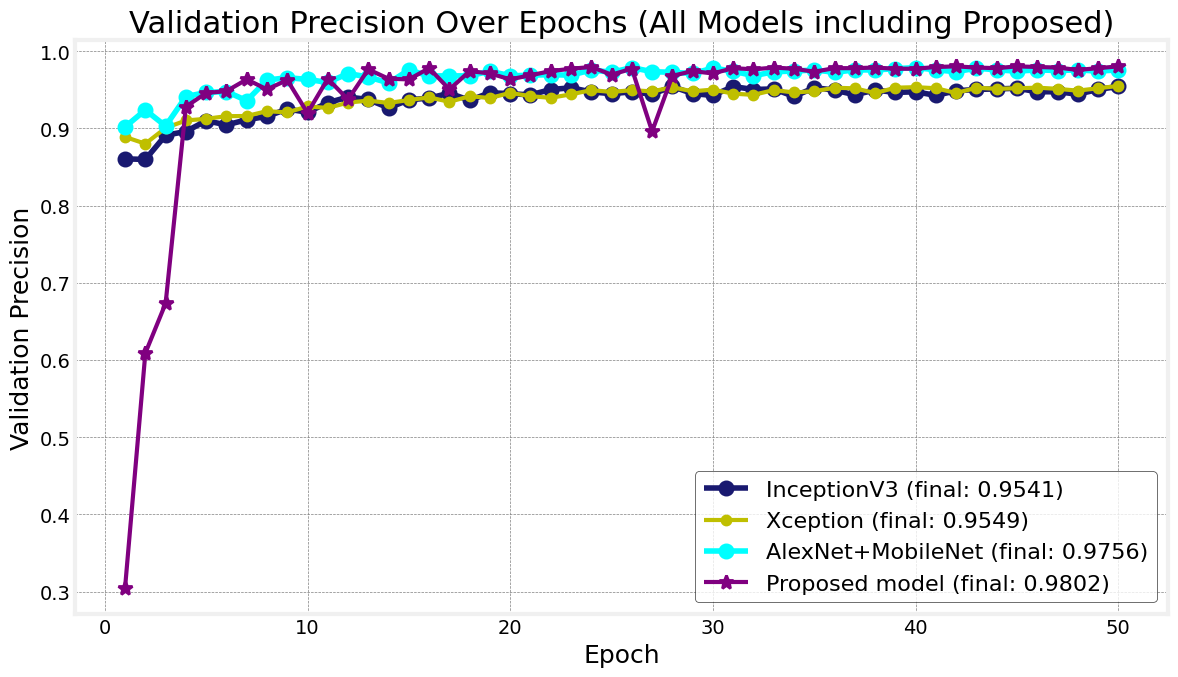

In [360]:
import matplotlib.pyplot as plt

# Model 1 (InceptionV3)
val_precision_1 = hist.history['val_precision_2']
epochs_1 = range(1, len(val_precision_1) + 1)
last_val_precision_1 = val_precision_1[-1]

# Model 2 (Xception)
val_precision_2 = hista.history['val_precision_5']
epochs_2 = range(1, len(val_precision_2) + 1)
last_val_precision_2 = val_precision_2[-1]

# Model 3 (AlexNet+MobileNet)
val_precision_3 = histb.history['val_precision_7']
epochs_3 = range(1, len(val_precision_3) + 1)
last_val_precision_3 = val_precision_3[-1]

# Proposed Model
val_precision_p = histp.history['val_precision_16']
epochs_p = range(1, len(val_precision_p) + 1)
last_val_precision_p = val_precision_p[-1]

plt.figure(figsize=(12, 7), facecolor='white')

plt.plot(
    epochs_1, val_precision_1, color='midnightblue', marker='.', linestyle='-', 
    markersize=17, markerfacecolor='midnightblue', markeredgewidth=3, linewidth=4,
    label=f'InceptionV3 (final: {last_val_precision_1:.4f})'
)
plt.plot(
    epochs_2, val_precision_2, color='y', marker='.', linestyle='-', 
    markersize=13, markerfacecolor='y', markeredgewidth=2, linewidth=3,
    label=f'Xception (final: {last_val_precision_2:.4f})'
)
plt.plot(
    epochs_3, val_precision_3, color='cyan', marker='.', linestyle='-', 
    markersize=17, markerfacecolor='cyan', markeredgewidth=3, linewidth=4,
    label=f'AlexNet+MobileNet (final: {last_val_precision_3:.4f})'
)
plt.plot(
    epochs_p, val_precision_p, color='purple', marker='*', linestyle='-', 
    markersize=10, markerfacecolor='purple', markeredgewidth=2, linewidth=3,
    label=f'Proposed model (final: {last_val_precision_p:.4f})'
)

plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Validation Precision', fontsize=18, color='black')
plt.title('Validation Precision Over Epochs (All Models including Proposed)', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

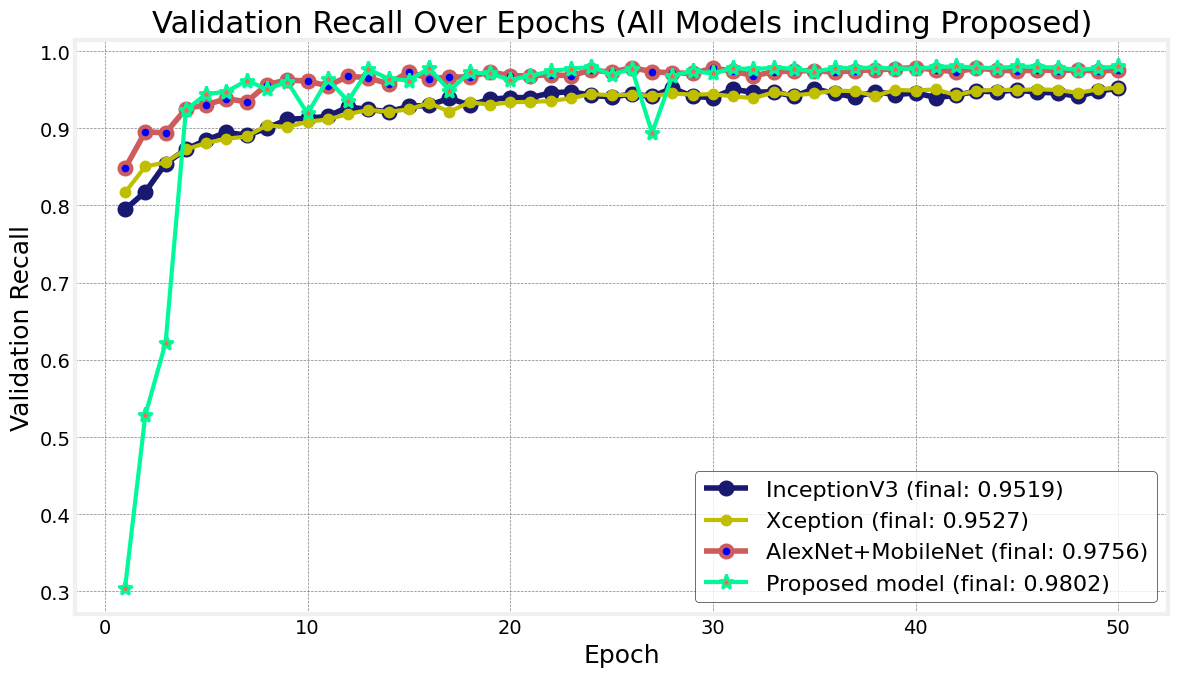

In [359]:
import matplotlib.pyplot as plt

# Model 1 (InceptionV3)
val_recall_1 = hist.history['val_recall_2']
epochs_1 = range(1, len(val_recall_1) + 1)
last_val_recall_1 = val_recall_1[-1]

# Model 2 (Xception)
val_recall_2 = hista.history['val_recall_5']
epochs_2 = range(1, len(val_recall_2) + 1)
last_val_recall_2 = val_recall_2[-1]

# Model 3 (AlexNet+MobileNet)
val_recall_3 = histb.history['val_recall_7']
epochs_3 = range(1, len(val_recall_3) + 1)
last_val_recall_3 = val_recall_3[-1]

# Proposed Model
val_recall_p = histp.history['val_recall_16']
epochs_p = range(1, len(val_recall_p) + 1)
last_val_recall_p = val_recall_p[-1]

plt.figure(figsize=(12, 7), facecolor='white')

plt.plot(
    epochs_1, val_recall_1, color='midnightblue', marker='.', linestyle='-', 
    markersize=17, markerfacecolor='midnightblue', markeredgewidth=3, linewidth=4,
    label=f'InceptionV3 (final: {last_val_recall_1:.4f})'
)
plt.plot(
    epochs_2, val_recall_2, color='y', marker='.', linestyle='-', 
    markersize=13, markerfacecolor='y', markeredgewidth=2, linewidth=3,
    label=f'Xception (final: {last_val_recall_2:.4f})'
)
plt.plot(
    epochs_3, val_recall_3, color='indianred', marker='.', linestyle='-', 
    markersize=17, markerfacecolor='b', markeredgewidth=3, linewidth=4,
    label=f'AlexNet+MobileNet (final: {last_val_recall_3:.4f})'
)
plt.plot(
    epochs_p, val_recall_p, color='mediumspringgreen', marker='*', linestyle='-', 
    markersize=11, markerfacecolor='tomato', markeredgewidth=2, linewidth=3,
    label=f'Proposed model (final: {last_val_recall_p:.4f})'
)

plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Validation Recall', fontsize=18, color='black')
plt.title('Validation Recall Over Epochs (All Models including Proposed)', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

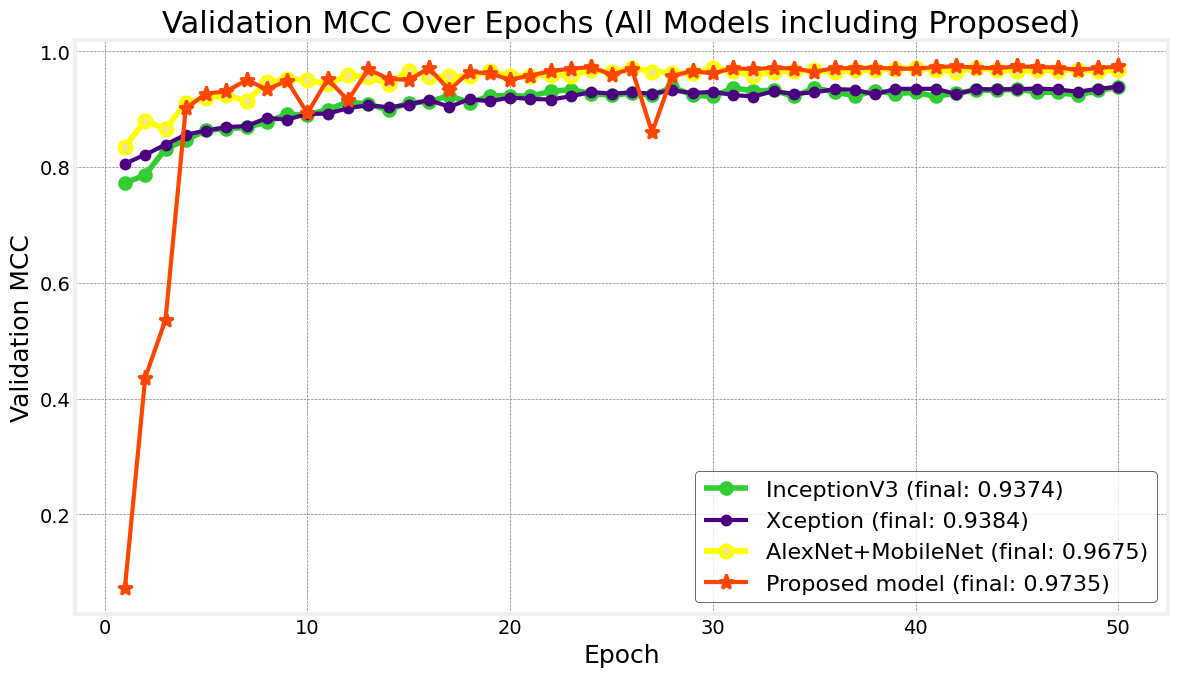

In [357]:
import matplotlib.pyplot as plt

# Model 1 (InceptionV3)
val_mcc_1 = hist.history['val_matthews_correlation']
epochs_1 = range(1, len(val_mcc_1) + 1)
last_val_mcc_1 = val_mcc_1[-1]

# Model 2 (Xception)
val_mcc_2 = hista.history['val_matthews_correlation_a']
epochs_2 = range(1, len(val_mcc_2) + 1)
last_val_mcc_2 = val_mcc_2[-1]

# Model 3 (AlexNet+MobileNet)
val_mcc_3 = histb.history['val_matthews_correlation_b']
epochs_3 = range(1, len(val_mcc_3) + 1)
last_val_mcc_3 = val_mcc_3[-1]

# Proposed Model
val_mcc_p = histp.history['val_matthews_correlation_b']
epochs_p = range(1, len(val_mcc_p) + 1)
last_val_mcc_p = val_mcc_p[-1]

plt.figure(figsize=(12, 7), facecolor='white')

plt.plot(
    epochs_1, val_mcc_1, color='limegreen', marker='.', linestyle='-', 
    markersize=15, markerfacecolor='limegreen', markeredgewidth=3, linewidth=4,
    label=f'InceptionV3 (final: {last_val_mcc_1:.4f})'
)
plt.plot(
    epochs_2, val_mcc_2, color='indigo', marker='.', linestyle='-', 
    markersize=13, markerfacecolor='indigo', markeredgewidth=2, linewidth=3,
    label=f'Xception (final: {last_val_mcc_2:.4f})'
)
plt.plot(
    epochs_3, val_mcc_3, color='yellow', marker='.', linestyle='-', 
    markersize=17, markerfacecolor='khaki', markeredgewidth=3, linewidth=4,
    label=f'AlexNet+MobileNet (final: {last_val_mcc_3:.4f})'
)
plt.plot(
    epochs_p, val_mcc_p, color='orangered', marker='*', linestyle='-', 
    markersize=11, markerfacecolor='orangered', markeredgewidth=2, linewidth=3,
    label=f'Proposed model (final: {last_val_mcc_p:.4f})'
)

plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Validation MCC', fontsize=18, color='black')
plt.title('Validation MCC Over Epochs (All Models including Proposed)', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

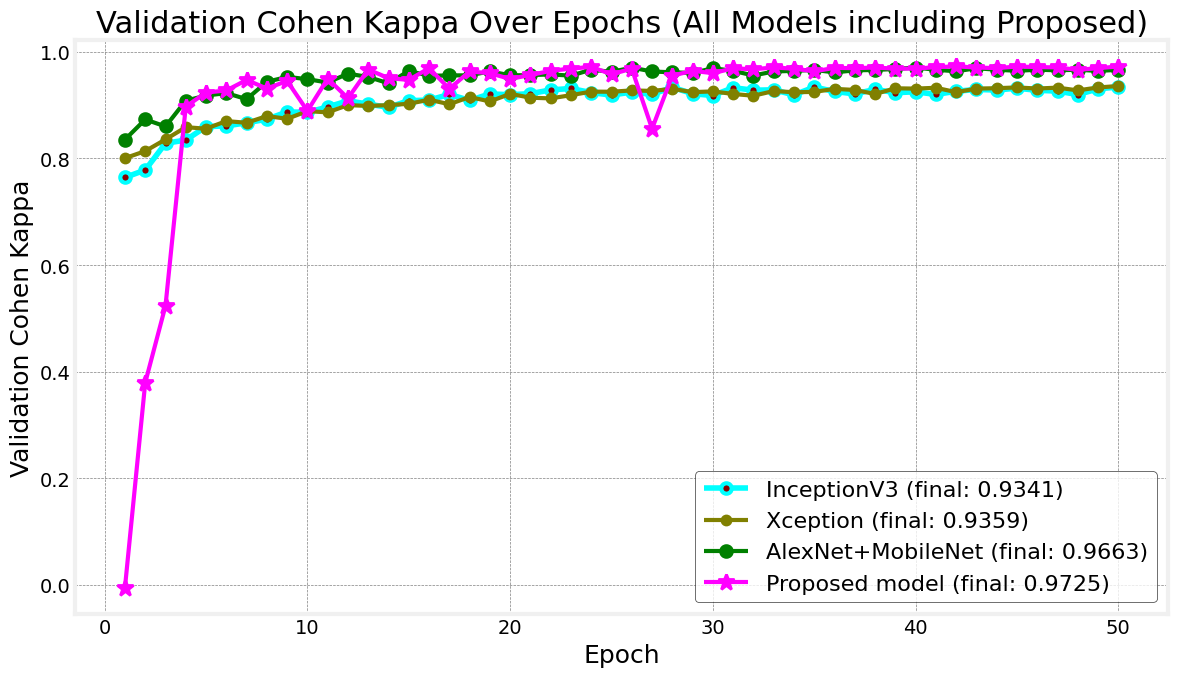

In [355]:
import matplotlib.pyplot as plt

# Model 1 (InceptionV3)
val_kappa_1 = hist.history['val_cohen_kappa']
epochs_1 = range(1, len(val_kappa_1) + 1)
last_val_kappa_1 = val_kappa_1[-1]

# Model 2 (Xception)
val_kappa_2 = hista.history['val_cohen_kappa_a']
epochs_2 = range(1, len(val_kappa_2) + 1)
last_val_kappa_2 = val_kappa_2[-1]

# Model 3 (AlexNet+MobileNet)
val_kappa_3 = histb.history['val_cohen_kappa_b']
epochs_3 = range(1, len(val_kappa_3) + 1)
last_val_kappa_3 = val_kappa_3[-1]

# Proposed Model
val_kappa_p = histp.history['val_cohen_kappa_b']
epochs_p = range(1, len(val_kappa_p) + 1)
last_val_kappa_p = val_kappa_p[-1]

plt.figure(figsize=(12, 7), facecolor='white')

plt.plot(
    epochs_1, val_kappa_1, color='aqua', marker='.', linestyle='-', 
    markersize=15, markerfacecolor='darkred', markeredgewidth=3, linewidth=4,
    label=f'InceptionV3 (final: {last_val_kappa_1:.4f})'
)
plt.plot(
    epochs_2, val_kappa_2, color='olive', marker='.', linestyle='-', 
    markersize=13, markerfacecolor='olive', markeredgewidth=2, linewidth=3,
    label=f'Xception (final: {last_val_kappa_2:.4f})'
)
plt.plot(
    epochs_3, val_kappa_3, color='green', marker='.', linestyle='-', 
    markersize=15, markerfacecolor='green', markeredgewidth=3, linewidth=3,
    label=f'AlexNet+MobileNet (final: {last_val_kappa_3:.4f})'
)
plt.plot(
    epochs_p, val_kappa_p, color='magenta', marker='*', linestyle='-', 
    markersize=12, markerfacecolor='magenta', markeredgewidth=2, linewidth=3,
    label=f'Proposed model (final: {last_val_kappa_p:.4f})'
)

plt.xlabel('Epoch', fontsize=18, color='black')
plt.ylabel('Validation Cohen Kappa', fontsize=18, color='black')
plt.title('Validation Cohen Kappa Over Epochs (All Models including Proposed)', fontsize=22, color='black')
plt.legend(facecolor='white', edgecolor='black', fontsize=16)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.gca().set_facecolor('white')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()